In [1]:
import pandas as pd
import re
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, f1_score, roc_auc_score, make_scorer
from gensim.models import Word2Vec
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
#!jupyter contrib nbextension install --user
#pip install jupyter_contrib_nbextensions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Введение

## Заказчик

Сервис по подбору репетиторов Repetit.ru

## Описание проекта


Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой
стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом
обработка заявки консультантом увеличивает конверсию в оплату на 30%.
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем
меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.

## Задачи

Разработать модель, которая по имеющейся информации о клиенте и заявке будет предсказывать
вероятность оплаты заявки клиентом. Заказчик хочет понять, какие заявки будут оплачены, а какие нет,
чтобы одни обрабатывать вручную консультантами, а другие нет. Оценка качества модели будет
производиться с использованием precision и ROC-AUC.

# Разведочный анализ (EDA)

## Выгрузка и осмотр данных

In [2]:
#выгружаем данные
path = 'C:/Users/vrakh/OneDrive/Рабочий стол/project/datasets/'

orders = pd.read_feather(path + 'orders.feather')
suitable_teachers = pd.read_feather(path + 'suitable_teachers.feather')
teachers_info = pd.read_feather(path + 'teachers_info.feather')
prefered_teachers_order_id = pd.read_feather(path + 'prefered_teachers_order_id.feather')

In [3]:
#Просмотрим данные
print('orders')
display(orders.head())
print('suitable_teachers')
display(suitable_teachers.head())
print('teachers_info')
display(teachers_info.head())
print('prefered_teachers_order_id')
display(prefered_teachers_order_id.head())

orders


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.000,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.000,675960,7.000,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.000,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.000,675960,7.000,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.000,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.000,16,None,NaN,0,7,None,NaN,14.000,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.000,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.000,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.000,16,None,NaN,0,10,None,47749.000,10.000,3,0,3,5,0,4,0,20,90,0,0,14,2293804.000,1024340,17.000,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.000,None,0,60,None,122.000,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.000,NaN,None,None,1


suitable_teachers


,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1


teachers_info


,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,1138.000,237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,1138.000,6,2022-05-16 18:44:59.993,0,3702.000,2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,2182.000,3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,2084.000,1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподго

prefered_teachers_order_id


,order_id,teacher_id
0,2469225,19663
1,2470455,19663
2,2480251,19663
3,2481259,19663
4,2483171,19663


In [4]:
#Просмотрим данные
print('orders')
display(orders.info())
print('suitable_teachers')
display(suitable_teachers.info())
print('teachers_info')
display(teachers_info.info())
print('prefered_teachers_order_id')
display(prefered_teachers_order_id.info())

orders
<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null      

None

suitable_teachers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


None

teachers_info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null 

None

prefered_teachers_order_id
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB


None

In [5]:
#Определим размерность данных
print('orders')
display(orders.shape)
print('suitable_teachers')
display(suitable_teachers.shape)
print('teachers_info')
display(teachers_info.shape)
print('prefered_teachers_order_id')
display(prefered_teachers_order_id.shape)

orders


(1191861, 38)

suitable_teachers


(20271186, 5)

teachers_info


(307972, 80)

prefered_teachers_order_id


(1135198, 2)

In [6]:
#Определим пропуски
print('orders')
display(orders.isna().sum())
print('suitable_teachers')
display(suitable_teachers.isna().sum())
print('teachers_info')
display(teachers_info.isna().sum())
print(prefered_teachers_order_id)
display(prefered_teachers_order_id.isna().sum())

orders


id                               0
order_date                       0
subject_id                   10332
purpose                     166510
lesson_price                     0
lesson_duration                  0
lesson_place               1191830
home_metro_id               549414
add_info                    147173
start_date                  486283
working_teacher_id          485873
status_id                        0
comments                    850393
prefered_teacher_id        1191857
amount_to_pay                    0
planned_lesson_number            0
first_lesson_date          1025290
creator_id                  612163
pupil_category_new_id       159391
lessons_per_week                 0
minimal_price                    0
teacher_sex                      0
teacher_experience_from          0
teacher_experience_to            0
lesson_place_new                 0
pupil_knowledgelvl               0
teacher_age_from                 0
teacher_age_to                   0
chosen_teachers_only

suitable_teachers


teacher_id                   0
order_id                     0
contact_result        12824362
enable_auto_assign           0
enable_assign                0
dtype: int64

teachers_info


id                                 0
date_update                        0
reg_date                           0
birth_date                         0
teaching_start_date                0
user_id                            0
is_email_confirmed                 0
is_home_lessons                    0
is_external_lessons                0
external_comments             216994
lesson_duration                    0
lesson_cost                        0
status_id                          0
status_relevant_date          261593
status_school_id              293099
status_college_id             301429
status_display                     0
russian_level_id                   0
home_country_id                    0
information                   175000
is_confirmed                       0
external_comments.1           216994
lesson_duration.1                  0
lesson_cost.1                      0
status_id.1                        0
status_relevant_date.1        261593
status_school_id.1            293099
s

         order_id  teacher_id
0         2469225       19663
1         2470455       19663
2         2480251       19663
3         2481259       19663
4         2483171       19663
...           ...         ...
1135193   2372921      256667
1135194   2398454      256667
1135195   2100345      256668
1135196   2109696      256668
1135197   2615715      256670

[1135198 rows x 2 columns]


order_id      0
teacher_id    0
dtype: int64

In [7]:
#Определим явные дубликаты
print('orders')
display(orders.duplicated().sum())
print('suitable_teachers')
display(suitable_teachers.duplicated().sum())
print('teachers_info')
display(teachers_info.duplicated().sum())
print('prefered_teachers_order_id')
display(prefered_teachers_order_id.duplicated().sum())

orders


900

suitable_teachers


49

teachers_info


0

prefered_teachers_order_id


16

## Таблица Orders

Проведем анализ

In [8]:
#Еще раз посмотрим пропуски
orders.isna().sum()

id                               0
order_date                       0
subject_id                   10332
purpose                     166510
lesson_price                     0
lesson_duration                  0
lesson_place               1191830
home_metro_id               549414
add_info                    147173
start_date                  486283
working_teacher_id          485873
status_id                        0
comments                    850393
prefered_teacher_id        1191857
amount_to_pay                    0
planned_lesson_number            0
first_lesson_date          1025290
creator_id                  612163
pupil_category_new_id       159391
lessons_per_week                 0
minimal_price                    0
teacher_sex                      0
teacher_experience_from          0
teacher_experience_to            0
lesson_place_new                 0
pupil_knowledgelvl               0
teacher_age_from                 0
teacher_age_to                   0
chosen_teachers_only

*Определим признаки, которые нам не потребуются в модели:*
- lesson_place - много пропусков
- home_metro_id - много пропусков
- add_info - много пропусков, объектный тип
- start_date - много пропусков, приводит к утечке данных
- prefered_teacher_id - много пропусков
- first_lesson_date - много пропусокв
- creator_id - много пропусков
- additional_status_id - приводит к утечке данных
- max_metro_distance - много пропусков
- estimated_fee - приводит к утечке данных
- payment_date - приводит к утечке данных
- comments - приводит к утечке данных
- clien_id - утечка данных

In [9]:
not_in_orders = [
    'amount_to_pay',
    'lesson_place',
    'home_metro_id',
    'add_info',
    'start_date',
    'prefered_teacher_id',
    'first_lesson_date',
    'creator_id',
    'additional_status_id',
    'max_metro_distance',
    'estimated_fee',
    'payment_date',
    'comments',
    'client_id'
]

In [10]:
orders = orders.drop(not_in_orders, axis=1)

Изучим оставшиеся признаки  


In [11]:
#присутствуют аномально высокие зачения во всех признаках (будем разбираться)
orders.describe()

,id,subject_id,lesson_price,lesson_duration,working_teacher_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,is_display_to_teachers
count,1191861.000,1181529.000,1191861.000,1191861.000,705988.000,1191861.000,1191861.000,1032470.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,1191861.000,582588.000,1191861.000
mean,2340488.449,21.387,2019.466,71.868,164486.094,24.364,19.521,22.868,14.233,212.987,13.299,12.687,12.111,14.076,11.607,19.555,28.635,0.022,0.091,28.770,2325827.000,0.964
std,344556.255,6157.319,916334.053,6130.494,81836.891,6130.578,6130.586,6586.807,6130.595,11111.446,6130.597,6130.598,6130.605,6130.596,6130.600,6130.600,6131.385,0.148,0.287,6130.570,348043.875,0.186
min,1742636.000,1.000,0.000,0.000,33.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-40.000,-110.000,0.000,0.000,0.000,263.000,0.000
25%,2041441.000,3.000,500.000,60.000,100913.000,7.000,10.000,8.000,2.000,0.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,14.000,2022765.000,1.000
50%,2341556.000,8.000,1000.000,60.000,169516.000,16.000,10.000,10.000,3.000,0.000,2.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,16.000,2318886.000,1.000
75%,2638720.000,13.000,1500.000,60.000,234330.250,16.000,10.000,12.000,4.000,0.000,3.000,1.000,0.000,4.000,0.000,20.000,40.000,0.000,0.000,23.000,2631660.000,1.000
max,3605505.000,3605505.000,1000000000.000,3605505.000,3605505.000,3605505.000,3605505.000,3605505.000,3605505.000,10000000.000,3605505.000,3605505.000,3605505.000,3605505.000,3605505.000,3605505.000,3605505.000,1.000,1.000,3605505.000,3605505.000,1.000


In [12]:
#Также в дате создания заказа присутствуют ошибки (года)
orders['order_date'].str[:4].value_counts()

order_date
2023    544063
2022    488170
2021    159624
0042         3
0029         1
Name: count, dtype: int64

In [13]:
#Определим явные дубликаты и удалим их
orders.duplicated().sum()

900

In [14]:
orders.drop_duplicates(inplace=True)

### lesson_price

In [15]:
#Создадим Функцию для нахождения выбросов в указанном столбце DataFrame.
def find_outliers(df, column_name):

    # Вычисление Q1 и Q3
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    # Вычисление IQR
    IQR = Q3 - Q1

    # Вычисление границ для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Определение значений, которые являются выбросами
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    
    return outliers


In [16]:
#Посмотри на столбец lesson_price
orders['lesson_price'].describe()

count      1190961.000
mean          2017.460
std         916675.504
min              0.000
25%            500.000
50%           1000.000
75%           1500.000
max     1000000000.000
Name: lesson_price, dtype: float64

In [17]:
#Посмотри какип самые высокие значения
orders['lesson_price'].sort_values(ascending=False)

21341     1000000000
81022       20000000
94824       10090000
363192      10000000
292373       7777777
             ...    
32695              0
32694              0
32673              0
32662              0
0                  0
Name: lesson_price, Length: 1190961, dtype: int32

In [18]:
#Присутствуют аномально высокие значаения, а также некорректные значения 
find_outliers(orders,'lesson_price').sort_values(by='lesson_price', ascending = False)

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,working_teacher_id,status_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,is_display_to_teachers
21341,1862907,2021-11-20 13:20:45.717,2.000,\n​Категория ученика : школьники 7 класса,1000000000,60,NaN,7,0,8.000,0,15,3,0,0,4,0,18,30,0,0,16,NaN,1
81022,1922597,2022-01-17 14:47:58.423,1.000,"\n​Разделы : школьный курс, .вузовский курс \...",20000000,60,NaN,7,1,9.000,0,50000,3,0,0,4,0,30,50,0,0,16,NaN,1
94824,2388889,2022-12-26 10:04:21.907,8.000,\n​Разделы : алгебра \n​Цель занятий : люблю м...,10090000,60,NaN,7,7,8.000,0,150000,3,0,0,4,0,18,80,0,0,16,NaN,1
363192,2206463,2022-09-19 18:23:30.640,2.000,\n​Цель занятий : Хочу что ты свн позанимался ...,10000000,60,NaN,7,10,7.000,7,10000000,1,0,0,1,0,18,30,0,0,16,2206462.000,1
292373,2135618,2022-08-16 01:46:00.420,25.000,\n​Разделы : иероглифика \n​Дополнения : серти...,7777777,60,NaN,7,10,16.000,7,10,2,0,0,2,0,18,30,0,0,16,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79990,2558607,2023-04-05 11:29:35.140,8.000,+ физика.\nРазделы: школьный курс.\nКатегория ...,3125,90,NaN,7,10,8.000,4,0,3,0,0,1,0,0,0,0,0,14,2475188.000,1
79988,2558605,2023-04-05 11:26:47.290,8.000,+ физика.\nРазделы: школьный курс.\nКатегория ...,3125,90,267463.000,16,10,8.000,4,0,3,0,0,1,0,0,0,0,0,14,2475188.000,1
76543,2475188,2023-02-09 23:37:07.720,8.000,+ физика.\nРазделы: школьный курс.\nКатегория ...,3125,90,271768.000,16,10,8.000,4,0,3,0,0,1,0,0,0,0,0,8,NaN,1
228561,2071517,2022-05-30 16:58:29.317,11.000,Разделы: школьный курс.\nДополнения: ЕГЭ.\nКа...,3100,90,5674.000,6,7,12.000,4,0,2,10,0,3,0,35,55,0,0,23,NaN,1


In [19]:
#Предположим, что 5000 рублей оптимальый потолок для цены

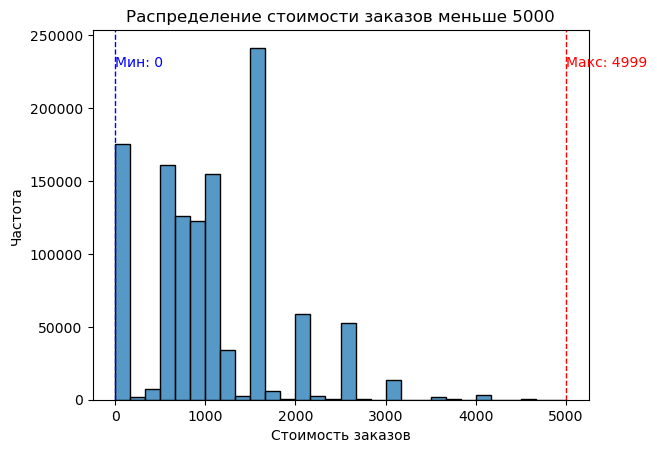

In [20]:
sns.histplot(orders[orders['lesson_price'] < 5000]['lesson_price'], bins=30)
plt.xlabel('Стоимость заказов')
plt.ylabel('Частота')
plt.title('Распределение стоимости заказов меньше 5000')

# Вычисление максимального и минимального значения
max_value = orders[orders['lesson_price'] < 5000]['lesson_price'].max()
min_value = orders[orders['lesson_price'] < 5000]['lesson_price'].min()

# Добавление вертикальных линий для максимального и минимального значений
plt.axvline(max_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(min_value, color='b', linestyle='dashed', linewidth=1)

# Добавление текстовых меток для максимального и минимального значений
plt.text(max_value, plt.ylim()[1]*0.9, f'Макс: {max_value}', color = 'red')
plt.text(min_value, plt.ylim()[1]*0.9, f'Мин: {min_value}', color = 'blue')

# Отображение графика
plt.show()

In [21]:
# заказов более 5000 руб - 1889, дропнем их
len(orders[orders['lesson_price'] > 5000]['lesson_price'])

1889

In [22]:
#В данных стоках содержатся ошибки, дропнем
orders.drop(orders[orders['lesson_price'] > 5000].index, inplace=True)

In [23]:
#Посмотрим на топ 10 сумм при оформлении заказа
top_10 = orders['lesson_price'].value_counts().head(10).sort_values()
top_10

lesson_price
600      31311
800      32714
2500     51890
2000     58634
700      89980
900     121043
500     126529
1000    150686
0       174054
1500    238084
Name: count, dtype: int64

In [24]:
#Количество остальных сумм
orders['lesson_price'].value_counts().sort_values(ascending=False).tail(233).sum()

108290

In [25]:
top_10.values

array([ 31311,  32714,  51890,  58634,  89980, 121043, 126529, 150686,
       174054, 238084], dtype=int64)

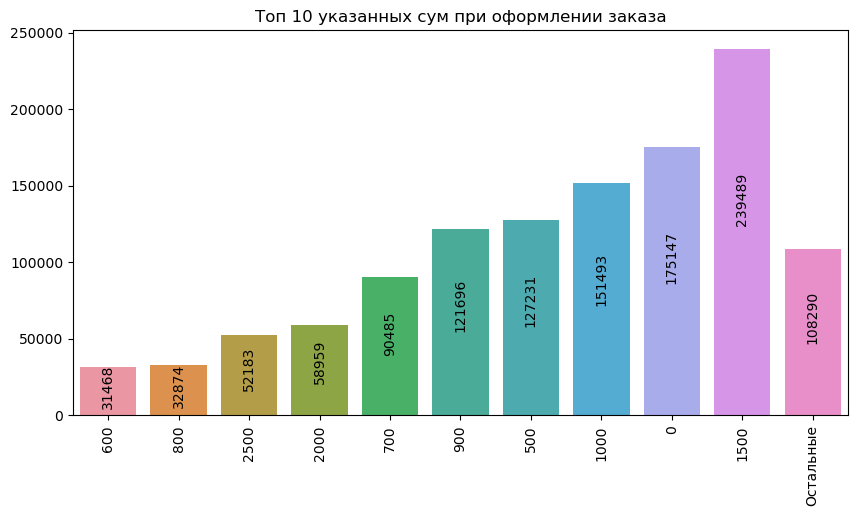

In [26]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=[ 600,  800, 2500, 2000,  700,  900,  500, 1000,    0, 1500, 'Остальные'], 
                 y=[ 31468,  32874,  52183,  58959,  90485, 121696, 127231, 151493, 175147, 239489, 108290])
plt.title('Топ 10 указанных сум при оформлении заказа')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/1.7),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 90)
plt.show()

Самые популярные суммы при оформлении заказа 1500 руб, 0 рублей, 1000 рублей

### order_date

In [27]:
#ошибки в датах также пропали после дропа
orders['order_date'].str[:4].value_counts()

order_date
2023    539492
2022    485797
2021    157926
Name: count, dtype: int64

In [28]:
#Переведем значения в формат дат
orders['order_date'] = pd.to_datetime(orders['order_date'])

In [29]:
#Посчитанием динамику заказов по месяцам
dynamics = orders[['id','order_date']]

In [30]:
dynamics.set_index('order_date', inplace=True)

In [31]:
#Проведем динамику заказаов по месяцам
dynamics = dynamics.resample('M').size()

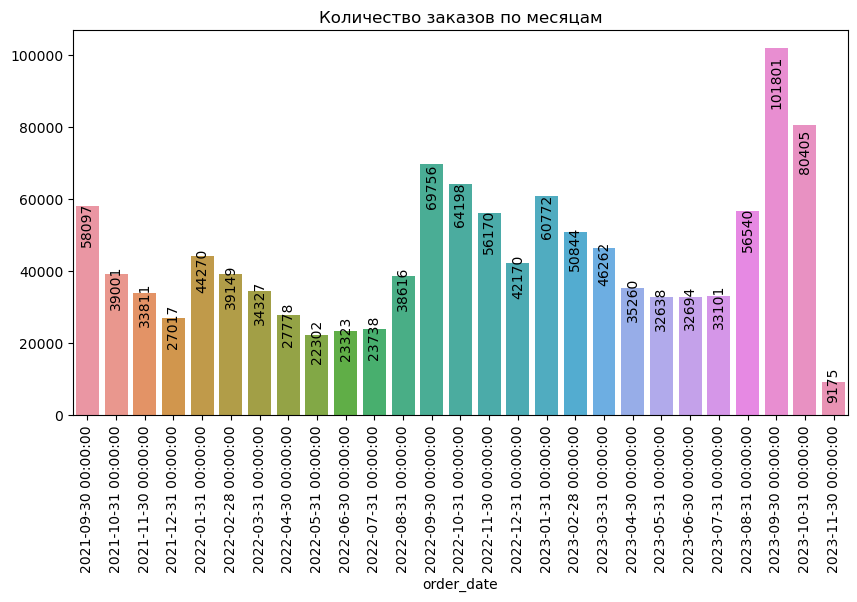

In [32]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=dynamics.index, y=dynamics.values);
plt.title('Количество заказов по месяцам')
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/1.1),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 90)
plt.show()

Больше всего заказов приходится на сентябрь

### lesson_duration

In [33]:
orders['lesson_duration'].describe()

count   1183215.000
mean         60.677
std           7.009
min           0.000
25%          60.000
50%          60.000
75%          60.000
max         135.000
Name: lesson_duration, dtype: float64

In [34]:
orders['lesson_duration'].value_counts().sort_values()

lesson_duration
135        161
0         1523
120       6949
45       19800
90       25337
60     1129445
Name: count, dtype: int64

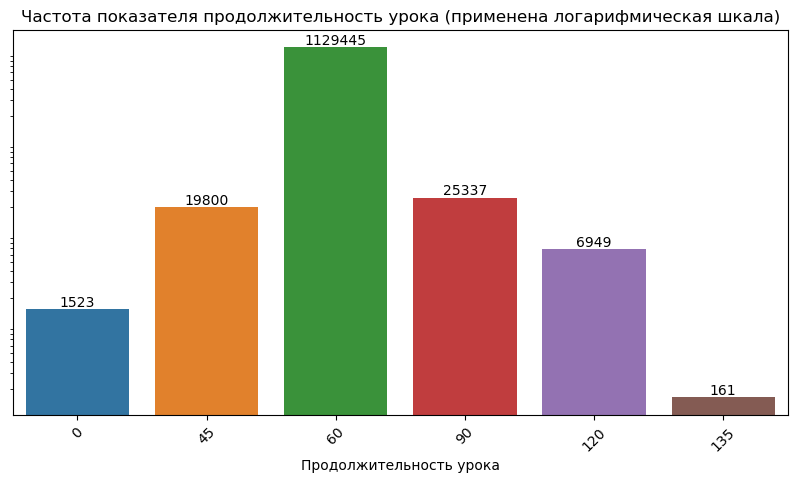

In [35]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=orders['lesson_duration'].value_counts().index,
                 y=orders['lesson_duration'].value_counts().values);
plt.title('Частота показателя продолжительность урока (применена логарифмическая шкала)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Продолжительность урока')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/0.85),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 0)
plt.show()

Самая популярная продолжителность урока 60 минут

### planned_lesson_number

In [36]:
orders['planned_lesson_number'].value_counts()

planned_lesson_number
10    931832
0     165552
7      67883
2      11516
1       6432
Name: count, dtype: int64

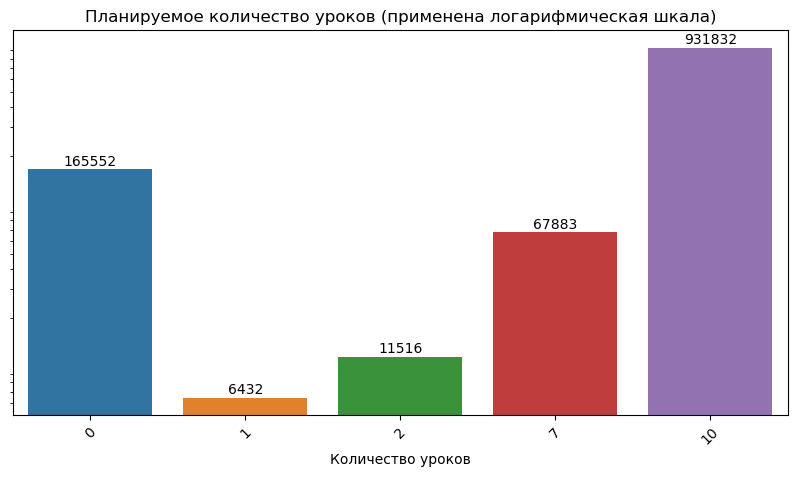

In [37]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=orders['planned_lesson_number'].value_counts().index,
                 y=orders['planned_lesson_number'].value_counts().values);
plt.title('Планируемое количество уроков (применена логарифмическая шкала)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Количество уроков')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/0.9),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 0)
plt.show()

Чаще всего указывают 10 уроков при заказе

### teacher_sex

In [38]:
orders.teacher_sex.value_counts()

teacher_sex
3    545400
2    389614
0    202481
1     45720
Name: count, dtype: int64

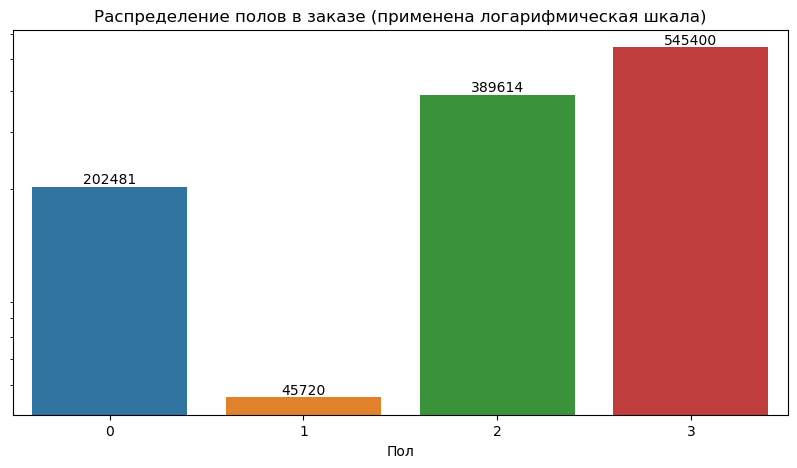

In [39]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=orders.teacher_sex.value_counts().index,
                 y=orders.teacher_sex.value_counts().values);
plt.title('Распределение полов в заказе (применена логарифмическая шкала)')
plt.xticks(rotation=0)
plt.yscale('log')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Пол')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/0.95),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 0)
plt.show()

Пол для учеников не особо важен, объединим значения 0 и 3

In [40]:
#Объединим значения 0 и 3
orders['teacher_sex'] = orders['teacher_sex'].replace(3, 0)
orders.teacher_sex.value_counts()

teacher_sex
0    747881
2    389614
1     45720
Name: count, dtype: int64

In [41]:
# Применение метода get_dummies для создания новых столбцов
dummies = pd.get_dummies(orders['teacher_sex'], prefix='sex')

# Оставить только столбцы с метками 1 и 2
selected_columns = ['sex_1', 'sex_2']

# Присоединить новые столбцы к датафрейму orders
orders[selected_columns] = dummies[selected_columns]

# Переименовать столбцы в 'male' и 'female'
orders.rename(columns={'sex_1': 'order_male', 'sex_2': 'order_female'}, inplace=True)

# Преобразовать значения в столбцах 'male' и 'female' в целые числа
orders[['order_male', 'order_female']] = orders[['order_male', 'order_female']].astype(int)

In [42]:
orders.drop('teacher_sex', axis=1, inplace=True)

### teacher_age_from teacher_age_to

In [43]:
orders['teacher_experience_from'].value_counts()

teacher_experience_from
0     839303
5     182439
1      60860
10     60368
2      13587
3      12946
4       5305
7       5010
6       1144
8        878
15       670
20       364
9         64
30        63
25        53
12        33
11        26
13        15
24        11
23         9
22         8
18         7
14         6
28         5
19         4
26         4
35         4
27         4
51         3
32         3
16         3
21         3
40         3
50         2
29         2
36         2
33         1
49         1
17         1
37         1
Name: count, dtype: int64

In [44]:
orders['teacher_experience_to'].value_counts()

teacher_experience_to
0      1166150
100       4864
50        3397
10        1917
60        1452
70        1367
80        1147
5         1019
90         570
30         270
40         191
55         158
20         128
81          99
1           57
35          54
65          48
25          32
32          30
12          29
15          28
45          26
42          26
22          16
27          11
17          10
3           10
49           9
7            6
8            6
6            6
21           5
28           5
41           5
29           4
18           4
4            4
24           4
85           3
46           3
47           3
33           3
16           3
23           3
37           3
48           3
39           2
38           2
43           2
44           2
66           2
13           2
75           2
14           2
26           1
2            1
9            1
34           1
31           1
19           1
36           1
88           1
82           1
99           1
500          1
Nam

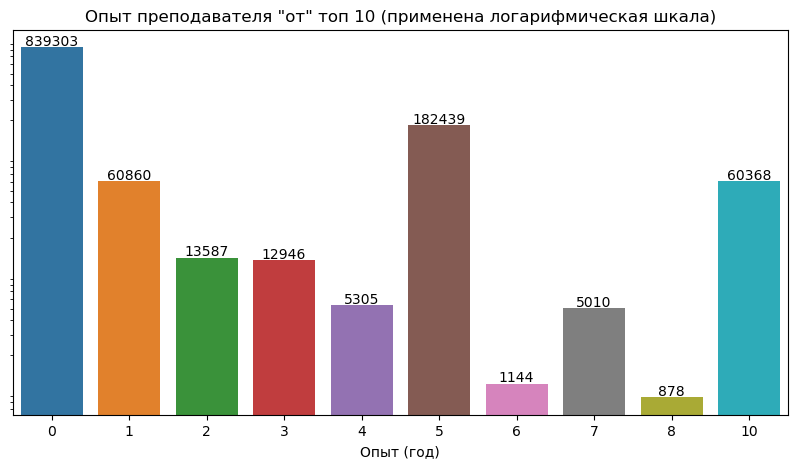

In [45]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=orders['teacher_experience_from'].value_counts().head(10).index,
                 y=orders['teacher_experience_from'].value_counts().head(10).values);
plt.title('Опыт преподавателя "от" топ 10 (применена логарифмическая шкала)')
plt.xticks(rotation=0)
plt.yscale('log')
plt.ylabel('')
plt.yticks([])
plt.xlabel('Опыт (год)')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/0.89),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 0)
plt.show()

Если судить по заказам, большей части клиентов опыт преподаватей ('teacher_experience_from') не важен  
'teacher_experience_to' показатель практически полностью состоит из 0

### chosen_teachers_only

In [46]:
orders['chosen_teachers_only'].value_counts(normalize=True)

chosen_teachers_only
0   0.978
1   0.022
Name: proportion, dtype: float64

Только 2% клиентов просят не предлагать других преподавателей

### no_teachers_available

In [47]:
orders['no_teachers_available'].value_counts(normalize=True)

no_teachers_available
0   0.909
1   0.091
Name: proportion, dtype: float64

в 9% случаях нет подходящих репетиторов

### is_display_to_teachers

In [48]:
orders['is_display_to_teachers'].value_counts(normalize=True)

is_display_to_teachers
1   0.964
0   0.036
Name: proportion, dtype: float64

в 4% заказов клиент не хотел получать отклики

### lesson_place_new

lesson_place_new Name 
- 0 Нет
- 1 У Ученика
- 2 У Репетитора
- 4 Удаленно
- 7 Любой
- Соответственно, 3=1+2 - у репетитора и ученика и т.д.

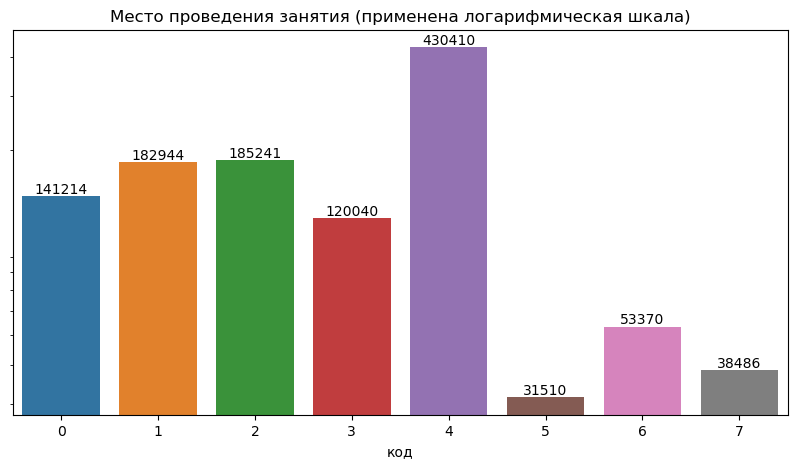

In [49]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=orders['lesson_place_new'].value_counts().index,
                 y=orders['lesson_place_new'].value_counts().values);
plt.title('Место проведения занятия (применена логарифмическая шкала)')
plt.xticks(rotation=0)
plt.yscale('log')
plt.ylabel('')
plt.yticks([])
plt.xlabel('код')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/0.95),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 0)
plt.show()

Чаще всего выбирают удаленку

### pupil_knowledgelvl

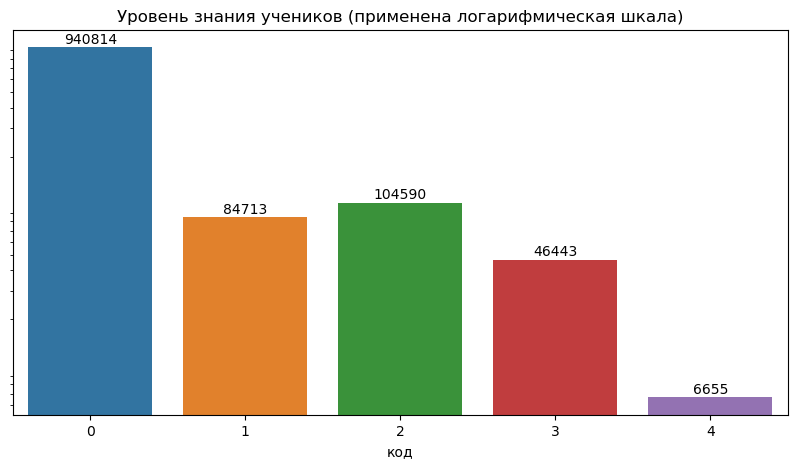

In [50]:
plt.figure(figsize=[10,5])
ax = sns.barplot(x=orders['pupil_knowledgelvl'].value_counts().index,
                 y=orders['pupil_knowledgelvl'].value_counts().values);
plt.title('Уровень знания учеников (применена логарифмическая шкала)')
plt.xticks(rotation=0)
plt.yscale('log')
plt.ylabel('')
plt.yticks([])
plt.xlabel('код')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()/0.89),
                ha = 'center', va = 'center', 
                xytext = (0, 0), textcoords = 'offset points',
                rotation = 0)
plt.show()

Чаще всего указывается значение 0

### first_order_id (новый признак)

In [51]:
#Создадим столбей с начальным id и заполним его
orders['first_order_id'] = orders['original_order_id']
orders['first_order_id'] = orders['first_order_id'].fillna(orders['id'])
orders[['id','original_order_id', 'first_order_id']].head(10)

,id,original_order_id,first_order_id
0,2294054,2294000.000,2294000.000
1,2294055,2294000.000,2294000.000
2,2294056,NaN,2294056.000
3,2294057,2293804.000,2293804.000
4,2294058,NaN,2294058.000
5,2294059,NaN,2294059.000
6,2294060,2294059.000,2294059.000
7,2294061,2294059.000,2294059.000
8,2294062,2294059.000,2294059.000
9,2294063,2294052.000,2294052.000


Теперь мы значаем номер начального id во вссех строках

In [52]:
#Создадим столбец (дубль status_id) согласно условию, где 5,6,13,15 равно 1, остальное 0
orders['status_id_2'] = orders['status_id'].apply(lambda x: 1 if x in [5,6,13,15] else 0)
orders[['status_id', 'status_id_2']]

,status_id,status_id_2
0,16,0
1,7,0
2,16,0
3,16,0
4,16,0
...,...,...
437211,16,0
437212,6,1
437213,16,0
437214,16,0


In [53]:
#удалим столбец status_id
orders.drop('status_id', axis=1, inplace=True)

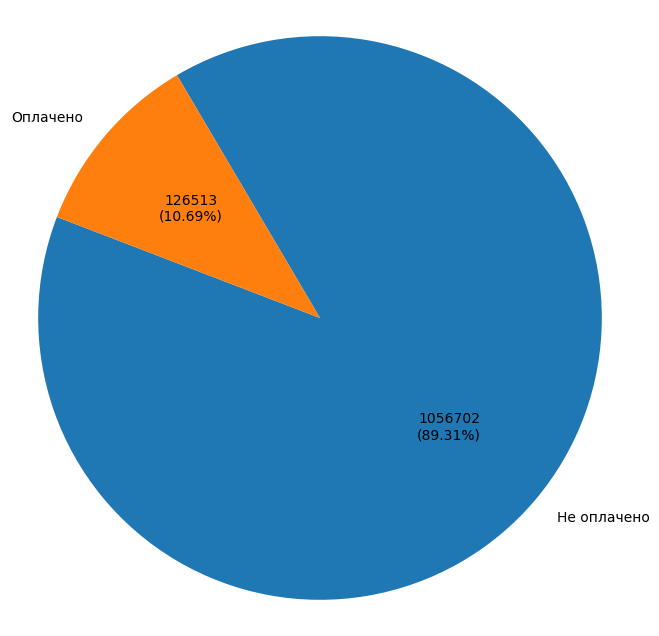

In [54]:
#Количество обплаченных и неоплаченных заказов
data = orders['status_id_2'].value_counts()

labels = ['Не оплачено', 'Оплачено']
values = data.values
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v}\n({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct
plt.figure(figsize=(8,8))
plt.pie(values, labels=labels, autopct=make_autopct(values), shadow=False, startangle=159)

plt.axis('equal')
plt.show()

На неоплаченные заказы приходится практически 90%

In [55]:
#Посмотрим сколько дублей может быть на один заказ
orders.groupby('first_order_id')['status_id_2'].count().sort_values()

first_order_id
2354589.000     1
2420746.000     1
2420744.000     1
2420741.000     1
2420735.000     1
               ..
2075564.000    80
2509516.000    84
2353479.000    88
2289774.000    90
1751638.000    99
Name: status_id_2, Length: 633476, dtype: int64

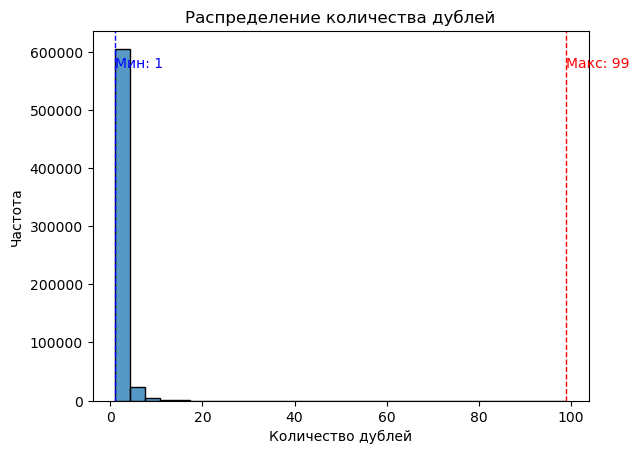

In [56]:
sns.histplot(orders.groupby('first_order_id')['status_id_2'].count(), bins=30)
plt.xlabel('Количество дублей')
plt.ylabel('Частота')
plt.title('Распределение количества дублей')

# Вычисление максимального и минимального значения
max_value = orders.groupby('first_order_id')['status_id_2'].count().max()
min_value = orders.groupby('first_order_id')['status_id_2'].count().min()

# Добавление вертикальных линий для максимального и минимального значений
plt.axvline(max_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(min_value, color='b', linestyle='dashed', linewidth=1)

# Добавление текстовых меток для максимального и минимального значений
plt.text(max_value, plt.ylim()[1]*0.9, f'Макс: {max_value}', color = 'red')
plt.text(min_value, plt.ylim()[1]*0.9, f'Мин: {min_value}', color = 'blue')

# Отображение графика
plt.show()

Чаще всего количество дублей варируется в пределах от 0 до 5-6, но бывают и экстримальные хначения например - 99

In [57]:
#Создадим признак, который определяет является ли заказ дублем
counts = orders.groupby('first_order_id')['status_id_2'].transform('size')
orders['dubl'] = (counts > 1).astype(int)

In [58]:
orders[['order_date','id','first_order_id', 'status_id_2', 'dubl']].sort_values(by='first_order_id').head(20)

,order_date,id,first_order_id,status_id_2,dubl
43845,2023-06-09 22:27:14.110,2631856,263.000,0,1
44412,2023-06-10 17:19:56.343,2632423,263.000,1,1
246848,2023-09-27 06:50:35.497,2834859,19367.000,0,1
282266,2023-10-09 13:41:39.743,2870278,19367.000,0,1
245221,2023-09-26 16:48:21.433,2833232,19367.000,0,1
246847,2023-09-27 06:50:19.440,2834858,19367.000,0,1
224761,2023-09-20 08:34:07.787,2812772,113952.000,0,0
335664,2022-09-08 09:51:12.270,2178915,134851.000,0,1
335662,2022-09-08 09:50:51.397,2178913,134851.000,0,1
74674,2023-02-09 09:47:30.737,2473319,138178.000,0,0


In [59]:
#Создадим признак, который считает номер дубля
dubl = orders[['id', 'first_order_id']]
dubl_sorted = dubl.sort_values(by=['first_order_id', 'id'])
dubl_sorted['count_dubls'] = dubl_sorted.groupby('first_order_id').cumcount() + 1
dubl_sorted['count_dubls'] = dubl_sorted['count_dubls'].apply(lambda x: x if x <= 5 else 5)
dubl_sorted

,id,first_order_id,count_dubls
43845,2631856,263.000,1
44412,2632423,263.000,2
245221,2833232,19367.000,1
246847,2834858,19367.000,2
246848,2834859,19367.000,3
...,...,...,...
348668,2936683,2936683.000,1
348258,2936273,2936924.000,1
312370,2900382,2937195.000,1
348351,2936366,2937205.000,1


In [60]:
#cоединим данные
orders = orders.merge(dubl_sorted, on=['id','first_order_id'], how='inner')

### minimal_price

In [61]:
orders.minimal_price.describe()

count   1183215.000
mean        183.164
std        1021.295
min           0.000
25%           0.000
50%           0.000
75%           0.000
max     1000000.000
Name: minimal_price, dtype: float64

In [62]:
orders.minimal_price.value_counts().head(10)

minimal_price
0       891022
500      94570
1000     70389
400      27963
700      23777
300      18390
800      15118
1500     11618
600       9870
2000      6160
Name: count, dtype: int64

In [63]:
#определим значения больше 10000 как выбросы и удалим их
len(orders[orders.minimal_price > 10000])

41

In [64]:
orders.drop(orders[orders.minimal_price > 10000].index, inplace=True)

### teacher_age_from

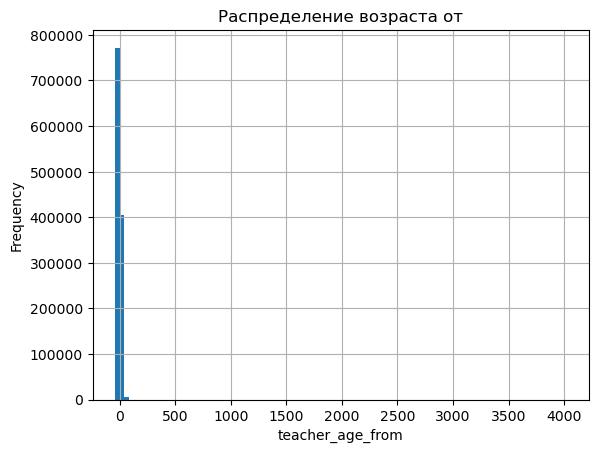

In [65]:
orders['teacher_age_from'].hist(bins=100)
plt.title('Распределение возраста от')
plt.xlabel('teacher_age_from')
plt.ylabel('Frequency');

In [66]:
display(orders['teacher_age_from'].max())
display(orders['teacher_age_from'].min())

4016

-40

In [67]:
#считаю данные значения выбросами и заменим их на медианные
orders[(orders['teacher_age_from'] > 70) | (orders['teacher_age_from'] < 0)]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,working_teacher_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,is_display_to_teachers,order_male,order_female,first_order_id,status_id_2,dubl,count_dubls
1576,2295647,2022-11-01 19:42:52.967,8.000,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 к...,1500,60,80832.000,10,10.000,4,0,10,0,1,0,89,90,0,0,23,2269457.000,1,0,1,2269457.000,0,1,2
1639,2295711,2022-11-01 20:02:10.100,8.000,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 к...,1500,60,NaN,10,10.000,4,0,10,0,1,0,89,90,0,0,14,2295647.000,1,0,1,2295647.000,0,1,1
1642,2295714,2022-11-01 20:02:53.437,8.000,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 к...,1500,60,NaN,10,10.000,4,0,10,0,1,0,89,90,0,0,14,2295647.000,1,0,1,2295647.000,0,1,2
2460,2296534,2022-11-02 12:10:21.507,8.000,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 к...,1500,60,NaN,10,10.000,4,0,10,0,1,0,89,90,0,0,14,2339938.000,1,0,1,2339938.000,0,1,1
2461,2296535,2022-11-02 12:10:42.473,8.000,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 9 к...,1500,60,NaN,10,10.000,4,0,10,0,1,0,89,90,0,0,14,2295647.000,1,0,1,2295647.000,0,1,3
26054,2320395,2022-11-15 04:59:57.833,2.000,Дополнения: подготовка к олимпиадам.\nКатегори...,500,60,NaN,7,12.000,2,0,10,0,4,4,80,0,0,0,23,NaN,1,0,1,2320395.000,0,0,1
48106,2342724,2022-11-26 18:05:36.970,2.000,Дополнения: PET.\nКатегория ученика: 5 класс.\...,1500,60,NaN,10,6.000,4,0,5,0,3,3,89,90,0,0,23,2341561.000,1,0,0,2341561.000,0,1,5
48365,2342985,2022-11-26 21:00:24.177,2.000,Дополнения: PET.\nКатегория ученика: 9 класс.\...,1500,60,NaN,10,10.000,4,0,5,0,3,3,89,60,0,0,23,2341561.000,1,0,1,2341561.000,0,1,5
112665,2289372,2022-10-29 00:00:37.450,13.000,Цели: улучшить успеваемость.\nКатегория ученик...,1500,60,201815.000,7,2.000,3,0,10,0,5,0,72,72,0,0,23,NaN,1,0,1,2289372.000,0,0,1
115028,2291762,2022-10-30 19:00:28.497,2.000,Цели: улучшить успеваемость.\nКатегория ученик...,1500,60,NaN,10,12.000,7,0,10,0,6,1,90,90,0,0,18,NaN,1,0,0,2291762.000,0,0,1


In [68]:
median_value = orders['teacher_age_from'].median()

In [69]:
orders['teacher_age_from'] = orders['teacher_age_from'].apply(lambda x: median_value if x < 0 or x > 70 else x)

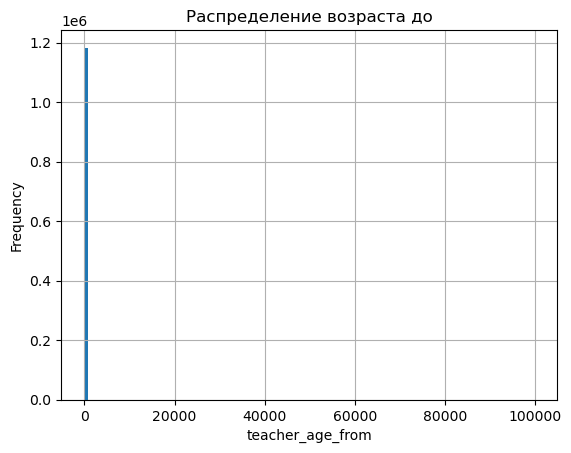

In [70]:
orders['teacher_age_to'].hist(bins=100)
plt.title('Распределение возраста до')
plt.xlabel('teacher_age_from')
plt.ylabel('Frequency');

In [71]:
display(orders['teacher_age_to'].max())
display(orders['teacher_age_to'].min())

99999

-110

In [72]:
#считаю данные значения выбросами и заменим их на медианные
orders[(orders['teacher_age_to'] > 70) | (orders['teacher_age_to'] < 0)]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,working_teacher_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,is_display_to_teachers,order_male,order_female,first_order_id,status_id_2,dubl,count_dubls
3,2294057,2022-11-01 00:08:47.237,8.000,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,236392.000,10,10.000,3,0,5,0,4,0,20.000,90,0,0,14,2293804.000,1,0,0,2293804.000,0,1,2
24,2294078,2022-11-01 01:42:48.730,1.000,Разделы: школьный курс.\nКатегория ученика: в...,1000,60,101215.000,10,15.000,4,600,0,0,6,0,40.000,80,0,0,16,NaN,1,0,1,2294078.000,0,1,1
27,2294081,2022-11-01 01:50:08.540,27.000,Разделы: живопись.\nКатегория ученика: Взрослы...,1500,60,NaN,10,15.000,3,0,5,0,3,0,30.000,90,0,0,23,2294079.000,1,0,0,2294079.000,0,1,2
28,2294082,2022-11-01 01:52:05.167,27.000,Разделы: живопись.\nКатегория ученика: Взрослы...,1500,60,NaN,10,15.000,3,0,0,0,3,0,16.000,90,0,0,23,2294079.000,1,0,0,2294079.000,0,1,3
29,2294083,2022-11-01 01:53:32.387,10.000,"Разделы: css, HTML, JavaScript, дизайн веб-сай...",1000,60,272283.000,2,14.000,3,0,0,0,7,0,16.000,90,0,0,23,NaN,1,0,0,2294083.000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183187,2280479,2022-10-24 19:31:17.020,36.000,Разделы: гимнастика.\nКатегория ученика: школь...,700,60,NaN,10,2.000,3,0,10,0,4,0,16.000,90,1,0,14,2277449.000,1,0,1,2277449.000,0,1,2
1183193,2280485,2022-10-24 19:34:31.690,2.000,"Цели: улучшить успеваемость, нагнать пропущенн...",2000,60,NaN,10,8.000,3,0,1,0,1,3,25.000,90,0,0,23,NaN,1,0,0,2280485.000,0,0,1
1183199,2280491,2022-10-24 19:39:20.710,15.000,Дополнения: ОГЭ (ГИА).\nКатегория ученика: 8 к...,900,60,NaN,10,9.000,5,0,5,0,2,0,16.000,90,0,0,23,NaN,1,0,0,2280491.000,0,0,1
1183204,2280496,2022-10-24 19:42:47.273,8.000,Цели: улучшить успеваемость.\nДополнения: ОГЭ ...,1500,60,NaN,10,10.000,3,0,5,0,5,0,0.000,90,0,0,17,NaN,1,0,0,2280496.000,0,0,1


Возможно людям не важен порог возраста учителя, заменим значения больше 70 и меньше 0 на медианное значение

In [73]:
median_value = orders['teacher_age_to'].median()

In [74]:
orders['teacher_age_to'] = orders['teacher_age_to'].apply(lambda x: median_value if x < 0 or x > 60 else x)

##  Таблица teachers_info

Проведем анализ

In [75]:
teachers_info.head(5)

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,1138.000,237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,1138.000,6,2022-05-16 18:44:59.993,0,3702.000,2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,2182.000,3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,2084.000,1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподго

In [76]:
#Определим явные дубликаты
teachers_info.duplicated().sum()

0

In [77]:
#Определим пропуски
teachers_info.isna().sum()

id                                 0
date_update                        0
reg_date                           0
birth_date                         0
teaching_start_date                0
user_id                            0
is_email_confirmed                 0
is_home_lessons                    0
is_external_lessons                0
external_comments             216994
lesson_duration                    0
lesson_cost                        0
status_id                          0
status_relevant_date          261593
status_school_id              293099
status_college_id             301429
status_display                     0
russian_level_id                   0
home_country_id                    0
information                   175000
is_confirmed                       0
external_comments.1           216994
lesson_duration.1                  0
lesson_cost.1                      0
status_id.1                        0
status_relevant_date.1        261593
status_school_id.1            293099
s

### date_update, reg_date , birth_date, teaching_start_date

In [78]:
#Переведем признаки к формату дат
teachers_info['date_update'] = pd.to_datetime(teachers_info['date_update'])
teachers_info['reg_date'] = pd.to_datetime(teachers_info['reg_date'])
teachers_info['birth_date'] = pd.to_datetime(teachers_info['birth_date'])
teachers_info['teaching_start_date'] = pd.to_datetime(teachers_info['teaching_start_date'])


In [79]:
teachers_info[['date_update','reg_date','birth_date','teaching_start_date']].describe()

,date_update,reg_date,birth_date
count,307972,307972,307972
mean,2023-03-29 23:22:42.034230272,2018-02-05 13:36:45.055023872,1989-11-25 10:12:30.137379456
min,2020-11-05 13:52:08.960000,2007-12-24 19:26:46,1775-02-01 00:00:00
25%,2023-01-19 14:32:03.525500160,2014-12-16 00:58:12.249999872,1985-03-10 00:00:00
50%,2023-01-19 18:01:16.797000192,2018-11-28 20:54:03.107000064,1992-10-14 00:00:00
75%,2023-06-15 17:36:36.491500032,2021-07-15 10:22:43.675500032,1998-09-17 00:00:00
max,2023-11-07 14:40:59.987000,2023-11-07 14:32:36.847000,2017-12-22 00:00:00


в признаке birth_date есть ошибочные значения

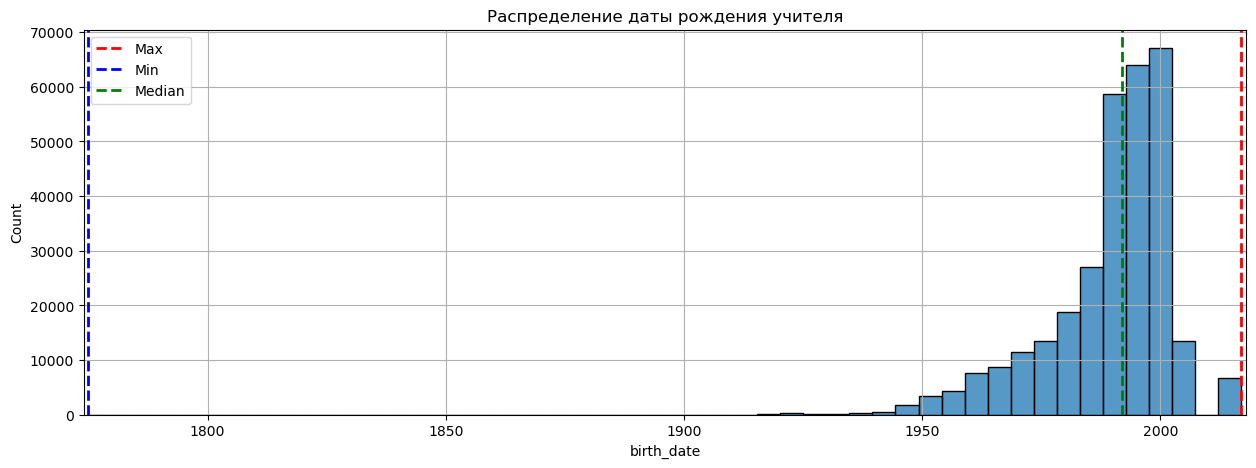

In [80]:
#Построим график с распределением возраста преподавателей
data = teachers_info['birth_date'].dt.year
plt.figure(figsize=[15,5])
ax = sns.histplot(data, bins=50, kde=False)
ax.axvline(x=max(data), color='r', linestyle='--', linewidth=2, label='Max')
ax.axvline(x=min(data), color='b', linestyle='--', linewidth=2, label='Min')
ax.axvline(x=np.median(data), color='g', linestyle='--', linewidth=2, label='Median')
ax.set_xlim([min(data) - 1, max(data) + 1])
ax.grid(True)
ax.legend()
plt.title('Распределение даты рождения учителя') 
plt.grid=True

In [81]:
#Предположим, что год рождения меньше 1933 года и больше 2005 являются ошибками, посморим сколько таких значений
teachers_info[(teachers_info['birth_date'].dt.year < 1933) | (teachers_info['birth_date'].dt.year > 2005)]

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
3002,3236,2023-01-19 17:38:11.067,2009-01-09 17:27:17.000,1919-01-01,1948-01-01,3281,0,1,1,2616+,60,300,1,NaN,NaN,NaN,1,5,7,6919+19,1,2616+,60,300,1,NaN,NaN,NaN,1,5,7,6919+19,1,2616+,60,300,1,NaN,NaN,NaN,1,5,7,NaN,6919+19,1,0,10,-10,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
3599,3846,2023-01-19 17:38:35.120,2009-02-17 15:36:52.000,1931-03-01,1984-01-01,3892,0,1,1,"Район станций метро: Преображенская площадь, С...",120,1000,5,NaN,NaN,NaN,1,5,7,Преподаватель на подготовительных курсах в Мос...,1,"Район станций метро: Преображенская площадь, С...",120,1000,5,NaN,NaN,NaN,1,5,7,Преподаватель на подготовительных курсах в Мос...,1,"Район станций метро: Преображенская площадь, С...",120,1000,5,NaN,NaN,NaN,1,5,7,NaN,Преподаватель на подготовительных курсах в Мос...,1,0,2,-1,19.02.09 Анкета проверена с преподавателем (Ол...,2014-08-12 00:00:00.000,NaN,1.000,0,2.000,1,NaN,1,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
4278,4549,2023-01-19 17:39:02.587,2009-04-01 20:06:14.000,1919-01-20,1976-01-01,4606,0,1,1,23432,34,43,1,NaN,NaN,NaN,1,5,7,23432,1,23432,34,43,1,NaN,NaN,NaN,1,5,7,23432,1,23432,34,43,1,NaN,NaN,NaN,1,5,7,NaN,23432,1,0,10,-10,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
4345,4616,2023-01-19 17:39:04.217,2009-04-05 22:22:22.000,1920-02-02,2003-01-01,4673,0,1,0,NaN,67,678,2,NaN,NaN,NaN,1,5,7,6574562424,1,NaN,67,678,2,NaN,NaN,NaN,1,5,7,6574562424,1,NaN,67,678,2,NaN,NaN,NaN,1,5,7,NaN,6574562424,1,0,10,-10,2424,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
4434,4706,2023-01-19 17:39:13.057,2009-04-10 22:35:06.000,1919-07-08,2006-01-01,4763,0,1,1,+100р,60,400,1,NaN,NaN,NaN,1,5,7,NaN,1,+100р,60,400,1,NaN,NaN,NaN,1,5,7,NaN,1,+100р,60,400,1,NaN,NaN,NaN,1,5,7,/teachers/4706/photo/photo_small.webp,NaN,1,0,10,-10,13.04.2009 11:32 - дубль анкеты 4654.,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300544,305194,2023-09-12 14:47:17.503,2023-09-05 11:58:10.803,2006-04-27,2022-09-01,1263368,0,1,1,NaN,45,2000,5,NaN,NaN

In [82]:
#Около 2%
7241/len(teachers_info)

0.02351187770316782

In [83]:
#Создадим признак с возрастом преподавателя
teachers_info['age'] = (2023 - teachers_info['birth_date'].dt.year)

In [84]:
teachers_info.drop('birth_date', axis=1, inplace=True)

In [85]:
#Создандим признак с опытом преподавателя
teachers_info['exp'] = (2023 - teachers_info['teaching_start_date'].dt.year)

In [86]:
teachers_info.drop('teaching_start_date', axis=1, inplace=True)

In [87]:
#Создандим признак с опытом преподавателя на платформе
teachers_info['exp_on_platform'] = (2023 - teachers_info['reg_date'].dt.year)

In [88]:
teachers_info.drop('reg_date', axis=1, inplace=True)

In [89]:
#Проведем анализ и выявим ошибочные значения
teachers_info[['exp_on_platform','exp', 'age']].describe()

,exp_on_platform,exp,age
count,307972.000,307972.000,307972.000
mean,5.426,14.886,33.590
std,4.075,18.971,13.119
min,0.000,0.000,6.000
25%,2.000,6.000,25.000
50%,5.000,11.000,31.000
75%,9.000,16.000,38.000
max,16.000,124.000,248.000


In [90]:
#как говорилось ранее, присутствую аномальные значения

Построим график распределеления опыта на платформе  
экстримальных значений не наблюдается

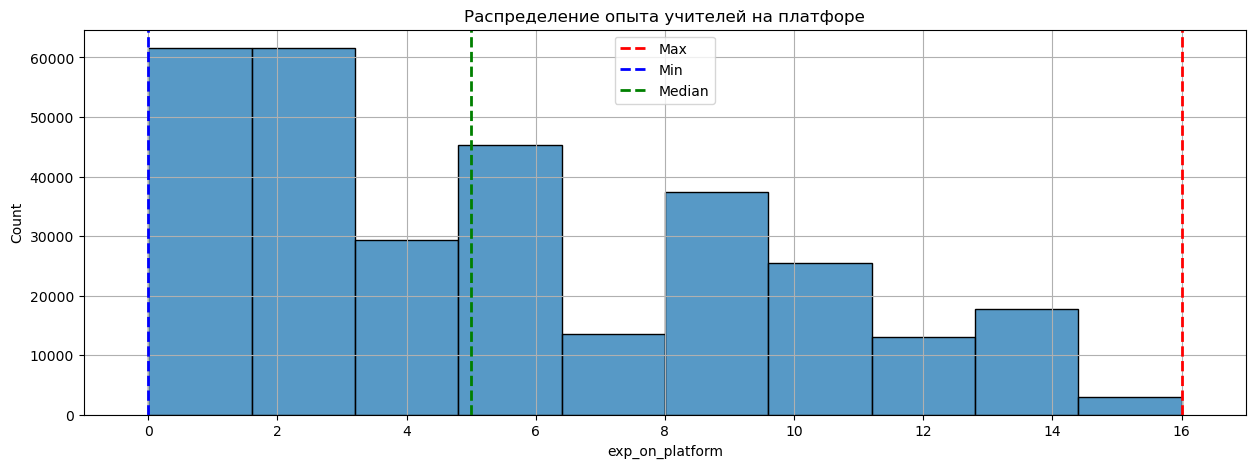

In [91]:
data = teachers_info['exp_on_platform']
plt.figure(figsize=[15,5])
ax = sns.histplot(data, bins=10, kde=False)
ax.axvline(x=max(data), color='r', linestyle='--', linewidth=2, label='Max')
ax.axvline(x=min(data), color='b', linestyle='--', linewidth=2, label='Min')
ax.axvline(x=np.median(data), color='g', linestyle='--', linewidth=2, label='Median')
ax.set_xlim([min(data) - 1, max(data) + 1])
ax.grid(True)
ax.legend()
plt.title('Распределение опыта учителей на платфоре') 
plt.grid=True

Построим график распределеления общего опыта преподавателя  
Имеются экстримальные значения, скорее всего связагны с ошибками при заполнении

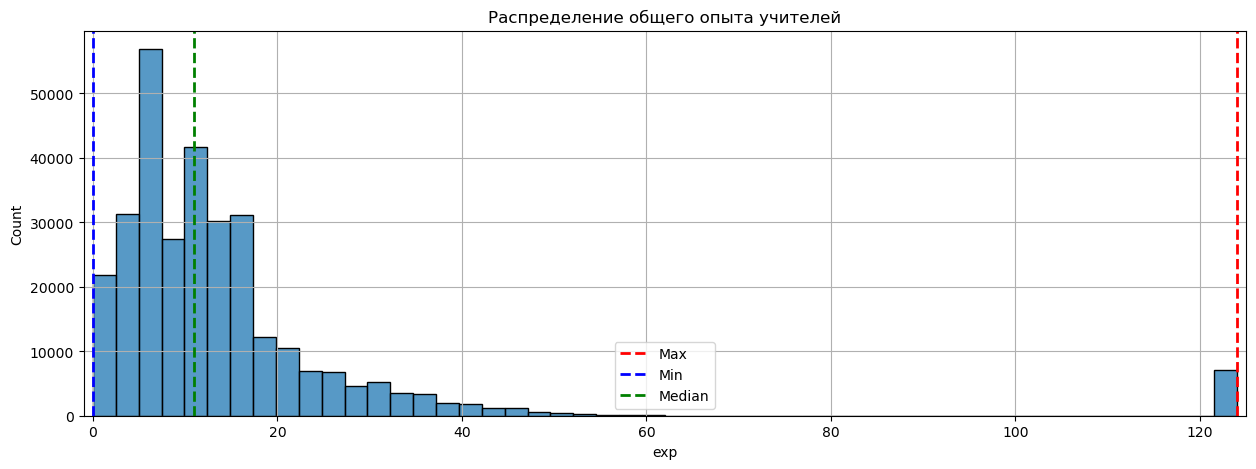

In [92]:
data = teachers_info['exp']
plt.figure(figsize=[15,5])
ax = sns.histplot(data, bins=50, kde=False)
ax.axvline(x=max(data), color='r', linestyle='--', linewidth=2, label='Max')
ax.axvline(x=min(data), color='b', linestyle='--', linewidth=2, label='Min')
ax.axvline(x=np.median(data), color='g', linestyle='--', linewidth=2, label='Median')
ax.set_xlim([min(data) - 1, max(data) + 1])
ax.grid(True)
ax.legend()
plt.title('Распределение общего опыта учителей') 
plt.grid=True

Построим график возраста учителя  
Имеются экстримальные значения, скорее всего связаны с ошибками при заполнении

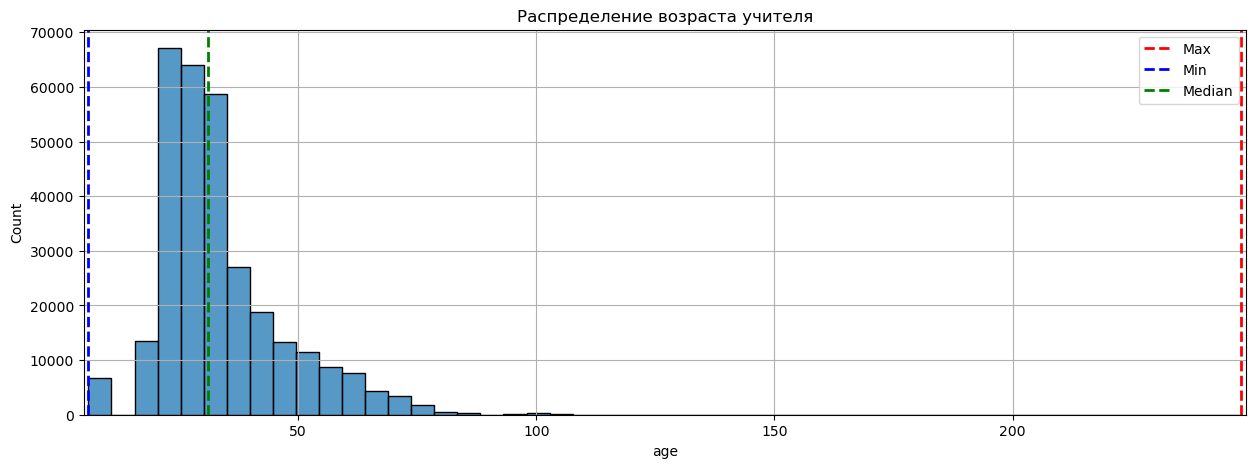

In [93]:
data = teachers_info['age']
plt.figure(figsize=[15,5])
ax = sns.histplot(data, bins=50, kde=False)
ax.axvline(x=max(data), color='r', linestyle='--', linewidth=2, label='Max')
ax.axvline(x=min(data), color='b', linestyle='--', linewidth=2, label='Min')
ax.axvline(x=np.median(data), color='g', linestyle='--', linewidth=2, label='Median')
ax.set_xlim([min(data) - 1, max(data) + 1])
ax.grid(True)
ax.legend()
plt.title('Распределение возраста учителя') 
plt.grid=True

Предположим, что репетиторами готовы стать дети от 15 лет и активные люди в возрасте не более 90 лет.  
Посмотрим сколько репетиторов попадает за пределы этого диапозона данных.

In [94]:
teachers_info.loc[(teachers_info['age'] >90) | (teachers_info['age'] <15)]

,id,date_update,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date,age,exp,exp_on_platform
3002,3236,2023-01-19 17:38:11.067,3281,0,1,1,2616+,60,300,1,NaN,NaN,NaN,1,5,7,6919+19,1,2616+,60,300,1,NaN,NaN,NaN,1,5,7,6919+19,1,2616+,60,300,1,NaN,NaN,NaN,1,5,7,NaN,6919+19,1,0,10,-10,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,104,75,14
3599,3846,2023-01-19 17:38:35.120,3892,0,1,1,"Район станций метро: Преображенская площадь, С...",120,1000,5,NaN,NaN,NaN,1,5,7,Преподаватель на подготовительных курсах в Мос...,1,"Район станций метро: Преображенская площадь, С...",120,1000,5,NaN,NaN,NaN,1,5,7,Преподаватель на подготовительных курсах в Мос...,1,"Район станций метро: Преображенская площадь, С...",120,1000,5,NaN,NaN,NaN,1,5,7,NaN,Преподаватель на подготовительных курсах в Мос...,1,0,2,-1,19.02.09 Анкета проверена с преподавателем (Ол...,2014-08-12 00:00:00.000,NaN,1.000,0,2.000,1,NaN,1,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,92,39,14
4278,4549,2023-01-19 17:39:02.587,4606,0,1,1,23432,34,43,1,NaN,NaN,NaN,1,5,7,23432,1,23432,34,43,1,NaN,NaN,NaN,1,5,7,23432,1,23432,34,43,1,NaN,NaN,NaN,1,5,7,NaN,23432,1,0,10,-10,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,104,47,14
4345,4616,2023-01-19 17:39:04.217,4673,0,1,0,NaN,67,678,2,NaN,NaN,NaN,1,5,7,6574562424,1,NaN,67,678,2,NaN,NaN,NaN,1,5,7,6574562424,1,NaN,67,678,2,NaN,NaN,NaN,1,5,7,NaN,6574562424,1,0,10,-10,2424,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,103,20,14
4434,4706,2023-01-19 17:39:13.057,4763,0,1,1,+100р,60,400,1,NaN,NaN,NaN,1,5,7,NaN,1,+100р,60,400,1,NaN,NaN,NaN,1,5,7,NaN,1,+100р,60,400,1,NaN,NaN,NaN,1,5,7,/teachers/4706/photo/photo_small.webp,NaN,1,0,10,-10,13.04.2009 11:32 - дубль анкеты 4654.,2014-08-12 00:00:00.000,NaN,1.000,0,-7.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,104,17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280315,284940,2023-01-28 01:17:16.303,1126083,0,0,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,0,NaN,60,0,5,NaN,NaN,NaN,0,0,7,NaN,NaN,0,1,1,0,NaN,2023-01-28 01:17:16.303,NaN,NaN,0,0.000,85,NaN,1,0,0,NaN,1,1,1,0.000,0.000,NaN,0,0,0.000,0,NaN,NaN,4.301,0.000,0,2023-01-28 01:17:16.303,1,NaN,Na

In [95]:
#Порядка 2% преподавателей, возможно указали не верные значения
round(7227/len(teachers_info),2)

0.02

Заменим значения возраста меньше 15 и больше 90 на медианное

In [96]:
age_median = teachers_info['age'].median()

In [97]:
teachers_info['age'] = teachers_info['age'].apply(lambda x: x if 15 <= x <= 90  else age_median)

Заменим значения опыта меньше больше 60 на медианное

In [98]:
exp_median = np.median(teachers_info['exp'])
exp_median

11.0

In [99]:
teachers_info['exp'] = teachers_info['exp'].apply(lambda x: x if x <= 60  else exp_median)

In [100]:
#Определим диапазоны возрастов
quantile_teachers_info_age = pd.qcut(teachers_info['age'], q = 4)
quantile_teachers_info_age.value_counts()

age
(25.0, 31.0]      84128
(15.999, 25.0]    80615
(38.0, 90.0]      75346
(31.0, 38.0]      67883
Name: count, dtype: int64

In [101]:
#Создадим функцию для категорий
def category_age(row):       
      
    if row['age'] <= 25:            
        return 'до 26 лет'  
    if row['age'] <= 31 and row['age'] > 25:  
        return '26-31 год'
    if row['age'] <= 38 and row['age'] > 31:
        return '32-38 лет'    
    if row['age'] > 38:
        return 'старше 38'
    else:                                
        return 'Нет данных'              
    
teachers_info['category_age'] = teachers_info.apply(category_age, axis=1)
teachers_info

,id,date_update,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date,age,exp,exp_on_platform,category_age
0,33,2023-11-07 14:20:28.323,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,1138.000,237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,1138.000,6,2022-05-16 18:44:59.993,0,3702.000,2023-11-06 14:20:15.173,40.000,34.000,16,старше 38
1,46,2023-01-19 17:36:42.233,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,43.000,20.000,16,старше 38
2,51,2023-05-25 09:04:45.243,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,2182.000,3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN,58.000,35.000,16,старше 38
3,52,2023-01-19 10:39:20.767,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,2084.000,1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN,35.000,17.000,16,32-38 лет
4,54,2023-01-19 16:28:36.517,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01,2008 Не очень хорошо повела себя при на ...",2014-08-12 00:00:00.000,NaN,1.000,0,-5.000,1,NaN,3,0,0,NaN,0,1,1,50.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,50.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,38.000,19.000,16,32-38 лет
...,...,.

Аналогично таблице orders создадим признак возраста от и до

In [102]:
#Создадим диапазон возрастов аналогично таблице orders
def category_age_from_to(row):
    if row['category_age'] == 'до 26 лет':
        return 16,25
    if row['category_age'] == '26-31 год':
        return 26,31
    if row['category_age'] == '32-38 лет':
        return 32,38
    if row['category_age'] == 'старше 38':
        return 39,90
    else:
        return 16,90

teachers_info['category_age_from'], teachers_info['category_age_to'] = \
zip(*teachers_info.apply(category_age_from_to, axis=1))
teachers_info

,id,date_update,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date,age,exp,exp_on_platform,category_age,category_age_from,category_age_to
0,33,2023-11-07 14:20:28.323,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,1138.000,237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,1138.000,6,2022-05-16 18:44:59.993,0,3702.000,2023-11-06 14:20:15.173,40.000,34.000,16,старше 38,39,90
1,46,2023-01-19 17:36:42.233,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,43.000,20.000,16,старше 38,39,90
2,51,2023-05-25 09:04:45.243,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,2182.000,3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN,58.000,35.000,16,старше 38,39,90
3,52,2023-01-19 10:39:20.767,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,2084.000,1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN,35.000,17.000,16,32-38 лет,32,38
4,54,2023-01-19 16:28:36.517,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01,2008 Не очень хорошо повела себя при на ...",2014-08-12 00:00:00.000,NaN,1.000,0,-5.000,1,NaN,3,0,0,NaN,0,1,1,50.000,0.000,NaN,0,1,0.000,1,NaN,NaN,4.301,50.000,0,2017-01-01 0

In [103]:
#Повторим аналогичную процедуру для общего опыта преподавателя
quantile_teachers_info_exp = pd.qcut(teachers_info['exp'], q = 4)
quantile_teachers_info_exp.value_counts()

exp
(-0.001, 6.0]    93088
(6.0, 11.0]      80079
(16.0, 60.0]     68406
(11.0, 16.0]     66399
Name: count, dtype: int64

In [104]:
def category_work_experience(row):       
      
    if row['exp'] <= 6:            
        return 'до 7 лет'  
    if row['exp'] <= 11 and row['exp'] > 6:  
        return '7-11 лет'
    if row['exp'] <= 16 and row['exp'] > 11:
        return '12-16 лет'    
    if row['exp'] > 16:
        return 'более 16'
    else:                                
        return 'unknown'              
    
teachers_info['category_work_exp'] = teachers_info.apply(category_work_experience, axis=1)
teachers_info

,id,date_update,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date,age,exp,exp_on_platform,category_age,category_age_from,category_age_to,category_work_exp
0,33,2023-11-07 14:20:28.323,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,1138.000,237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,1138.000,6,2022-05-16 18:44:59.993,0,3702.000,2023-11-06 14:20:15.173,40.000,34.000,16,старше 38,39,90,более 16
1,46,2023-01-19 17:36:42.233,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,43.000,20.000,16,старше 38,39,90,более 16
2,51,2023-05-25 09:04:45.243,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,2182.000,3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN,58.000,35.000,16,старше 38,39,90,более 16
3,52,2023-01-19 10:39:20.767,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,2084.000,1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN,35.000,17.000,16,32-38 лет,32,38,более 16
4,54,2023-01-19 16:28:36.517,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01,2008 Не очень хорошо повела себя при на ...",2014-08-12 00:00:00.000,NaN,1.000,0,-5.000,1,NaN,3,0,0,NaN,0,1,1,50.000,0.0

In [105]:
#Создадим дипазон
def category_work_experience_from_to(row):
    if row['category_work_exp'] == 'до 7 лет':
        return 0,6
    if row['category_work_exp'] == '7-11 лет':
        return 7,11
    if row['category_work_exp'] == '12-16 лет':
        return 12,16
    if row['category_work_exp'] == 'более 16':
        return 17,74
    else:
        return 0,74

teachers_info['category_work_experience_from'], teachers_info['category_work_experience_to'] = \
zip(*teachers_info.apply(category_work_experience_from_to, axis=1))
teachers_info

,id,date_update,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date,age,exp,exp_on_platform,category_age,category_age_from,category_age_to,category_work_exp,category_work_experience_from,category_work_experience_to
0,33,2023-11-07 14:20:28.323,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,1138.000,237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,1138.000,6,2022-05-16 18:44:59.993,0,3702.000,2023-11-06 14:20:15.173,40.000,34.000,16,старше 38,39,90,более 16,17,74
1,46,2023-01-19 17:36:42.233,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN,43.000,20.000,16,старше 38,39,90,более 16,17,74
2,51,2023-05-25 09:04:45.243,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,2182.000,3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN,58.000,35.000,16,старше 38,39,90,более 16,17,74
3,52,2023-01-19 10:39:20.767,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,2084.000,1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN,35.000,17.000,16,32-38 лет,32,38,более 16,17,74
4,54,2023-01-19 16:28:36.517,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01,2008 Не очень хорошо повела себя при н

### lesson_duration	

In [106]:
teachers_info.lesson_duration.describe()

count   307972.000
mean        61.503
std         15.062
min          1.000
25%         60.000
50%         60.000
75%         60.000
max        999.000
Name: lesson_duration, dtype: float64

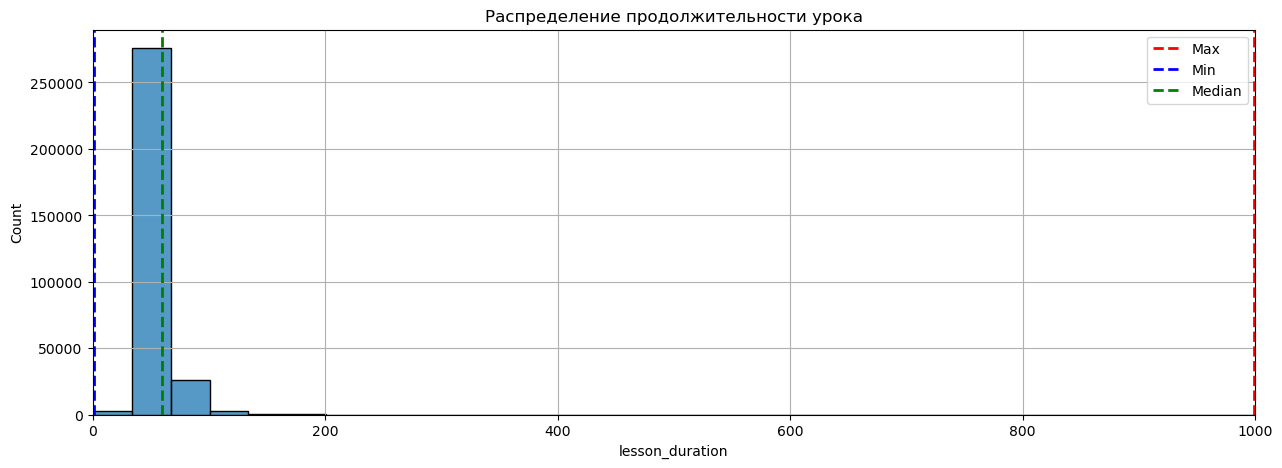

In [107]:
data = teachers_info['lesson_duration']
plt.figure(figsize=[15,5])
ax = sns.histplot(data, bins=30, kde=False)
ax.axvline(x=max(data), color='r', linestyle='--', linewidth=2, label='Max')
ax.axvline(x=min(data), color='b', linestyle='--', linewidth=2, label='Min')
ax.axvline(x=np.median(data), color='g', linestyle='--', linewidth=2, label='Median')
ax.set_xlim([min(data) - 1, max(data) + 1])
ax.grid(True)
ax.legend()
plt.title('Распределение продолжительности урока') 
plt.grid=True

Присутствуют аномальные значения

Заменим выбросы на самое популярное время - 60мин

In [108]:
teachers_info['lesson_duration'] = teachers_info['lesson_duration'].apply(lambda x: x if 30 <= x <= 200  else 60)

Проверим признаки 'lesson_duration.1' и 'lesson_duration', 'lesson_duration.2'

In [109]:
#Одинаковые признаки, удалим 2 из них
display(len(teachers_info['lesson_duration']))
display((teachers_info['lesson_duration'] == teachers_info['lesson_duration.1']).sum())
display((teachers_info['lesson_duration'] == teachers_info['lesson_duration.2']).sum())


307972

307751

307751

In [110]:
teachers_info.drop(['lesson_duration.1', 'lesson_duration.2'], axis=1, inplace=True)

### lesson_cost

Аналогично

In [111]:
#Одинаковые признаки, удалим 2 из них
display(len(teachers_info['lesson_cost']))
display((teachers_info['lesson_cost'] == teachers_info['lesson_cost']).sum())
display((teachers_info['lesson_cost'] == teachers_info['lesson_cost']).sum())


307972

307972

307972

In [112]:
teachers_info.drop(['lesson_cost.1', 'lesson_cost.2'], axis=1, inplace=True)

In [113]:
l_cost_med = teachers_info['lesson_cost'].median()
l_cost_med

500.0

In [114]:
#Заменим значения больше 5000 на медианное
teachers_info['lesson_cost'] = teachers_info['lesson_cost'].apply(lambda x: x if x <= 5000  else l_cost_med)

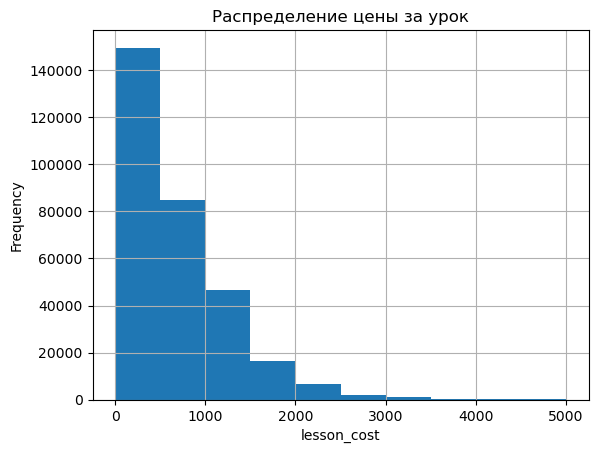

In [115]:
teachers_info['lesson_cost'].hist()
plt.title('Распределение цены за урок')
plt.xlabel('lesson_cost')
plt.ylabel('Frequency');

### sex

Посмотрим на распределение данных по полу репетиторов.

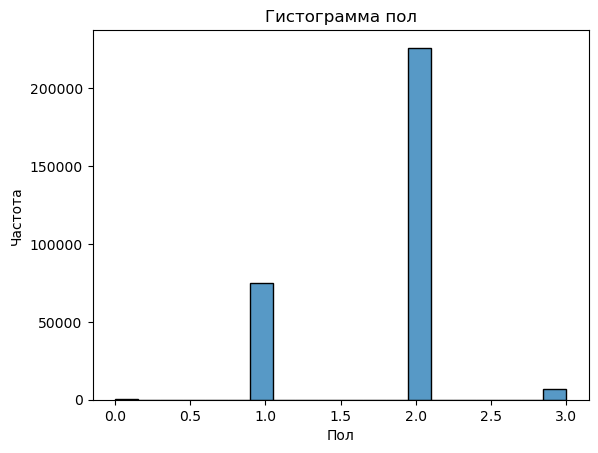

In [116]:
# Гистограмма возраста
sns.histplot(teachers_info['sex'], bins='auto')

plt.title('Гистограмма пол')
plt.xlabel('Пол')
plt.ylabel('Частота')
plt.show()

Большенство репетиторов женского пола. Категория 0 и 3 можно объединить в одну.

In [117]:
#Замена всех значений 3 на 0 в столбце 'sex'
teachers_info['sex'] = teachers_info['sex'].replace(3, 0)

In [118]:
# Применение метода get_dummies для создания новых столбцов
dummies_teachers_info = pd.get_dummies(teachers_info['sex'], prefix='sex')

# Оставить только столбцы с метками 1 и 2
selected_columns = ['sex_1', 'sex_2']

# Присоединить новые столбцы к датафрейму dummies_teachers_info
teachers_info[selected_columns] = dummies_teachers_info[selected_columns]

# Переименовать столбцы в 'male' и 'female'
teachers_info.rename(columns={'sex_1': 'male', 'sex_2': 'female'}, inplace=True)

# Преобразовать значения в столбцах 'male' и 'female' в целые числа
teachers_info[['male', 'female']] = teachers_info[['male', 'female']].astype(int)

### rating_id

Признаки связанные с рейтингом не анализировалаись, по принине непонятной градации значений

In [119]:
#Оставим признаки для teachers_info
teachers_info = teachers_info[['id', 'lesson_duration', 'lesson_cost', 'is_home_lessons',
       'is_external_lessons', 'is_remote_lessons', 'rating_id', 'rating',
       'effective_rating', 'rating_for_users', 'rating_for_admin',
       'star_rating', 'rating_for_users_yesterday', 'age', 'exp', 'male', 'female', 
       'exp_on_platform', 'category_age_from', 'category_age_to',
       'category_work_experience_from',  'category_work_experience_to']]

In [120]:
teachers_info.describe()

,id,lesson_duration,lesson_cost,is_home_lessons,is_external_lessons,is_remote_lessons,rating_id,rating,effective_rating,rating_for_users,rating_for_admin,star_rating,rating_for_users_yesterday,age,exp,male,female,exp_on_platform,category_age_from,category_age_to,category_work_experience_from,category_work_experience_to
count,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000,307972.000
mean,157246.177,61.384,524.928,0.422,0.599,0.511,10.222,-222.161,NaN,NaN,NaN,NaN,NaN,34.031,12.300,0.244,0.733,5.426,27.885,45.407,8.183,24.560
std,90198.005,12.087,594.898,0.494,0.490,0.500,6.351,4706.818,NaN,NaN,NaN,0.000,NaN,12.193,9.128,0.429,0.442,4.075,8.480,25.774,6.404,26.658
min,33.000,30.000,0.000,0.000,0.000,0.000,1.000,-100500.000,-10000.000,0.000,0.000,0.000,0.000,16.000,0.000,0.000,0.000,0.000,16.000,25.000,0.000,6.000
25%,79390.750,60.000,0.000,0.000,0.000,0.000,2.000,-2.000,0.000,0.000,0.000,4.301,0.000,25.000,6.000,0.000,0.000,2.000,16.000,25.000,0.000,6.000
50%,157384.500,60.000,500.000,0.000,1.000,1.000,13.000,0.000,0.000,120.000,0.000,4.301,120.000,31.000,11.000,0.000,1.000,5.000,26.000,31.000,7.000,11.000
75%,235434.250,60.000,900.000,1.000,1.000,1.000,15.000,5.000,0.000,225.000,0.000,4.301,225.000,38.000,16.000,0.000,1.000,9.000,32.000,38.000,12.000,16.000
max,312622.000,200.000,5000.000,1.000,1.000,1.000,28.000,10.000,11128.000,16960.000,20992.000,5.000,16928.000,90.000,60.000,1.000,1.000,16.000,39.000,90.000,17.000,74.000


## suitable_teachers + teachers_info (объединение таблиц)

In [121]:
#Выявим явные дубликаты и удалим их
suitable_teachers.duplicated().sum()

49

In [122]:
suitable_teachers.drop_duplicates(inplace=True)

In [123]:
#Удалим признак 'contact_result'
suitable_teachers.drop('contact_result', axis=1, inplace=True)

In [124]:
suitable_teachers.sort_values(by='teacher_id')

,teacher_id,order_id,enable_auto_assign,enable_assign
3963375,33,2147807,0,0
6754535,33,2429561,0,0
12068984,33,2645965,0,0
5745859,33,2334417,0,0
1964983,33,1950236,0,0
...,...,...,...,...
20267946,312609,2946590,0,0
20267872,312609,2946491,0,0
20255497,312613,2936484,0,1
20212432,312623,2944854,0,1


Соединим таблицы suitable_teachers и teachers_info

In [125]:
s_teachers_plus_t_info = teachers_info.merge(suitable_teachers, left_on='id', right_on='teacher_id', how='inner')

In [126]:
s_teachers_plus_t_info

,id,lesson_duration,lesson_cost,is_home_lessons,is_external_lessons,is_remote_lessons,rating_id,rating,effective_rating,rating_for_users,rating_for_admin,star_rating,rating_for_users_yesterday,age,exp,male,female,exp_on_platform,category_age_from,category_age_to,category_work_experience_from,category_work_experience_to,teacher_id,order_id,enable_auto_assign,enable_assign
0,33,60,1000.000,0,0,1,15,5,4.680,1138.000,237.500,4.500,1138.000,40.000,34.000,1,0,16,39,90,17,74,33,1758122,0,0
1,33,60,1000.000,0,0,1,15,5,4.680,1138.000,237.500,4.500,1138.000,40.000,34.000,1,0,16,39,90,17,74,33,1849803,0,0
2,33,60,1000.000,0,0,1,15,5,4.680,1138.000,237.500,4.500,1138.000,40.000,34.000,1,0,16,39,90,17,74,33,1841690,0,0
3,33,60,1000.000,0,0,1,15,5,4.680,1138.000,237.500,4.500,1138.000,40.000,34.000,1,0,16,39,90,17,74,33,1841973,0,0
4,33,60,1000.000,0,0,1,15,5,4.680,1138.000,237.500,4.500,1138.000,40.000,34.000,1,0,16,39,90,17,74,33,1883674,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20271130,312609,60,0.000,0,0,1,1,0,0.000,0.000,0.000,0.000,0.000,25.000,0.000,0,1,0,16,25,0,6,312609,2945783,1,0
20271131,312609,60,0.000,0,0,1,1,0,0.000,0.000,0.000,0.000,0.000,25.000,0.000,0,1,0,16,25,0,6,312609,2943759,0,0
20271132,312609,60,0.000,0,0,1,1,0,0.000,0.000,0.000,0.000,0.000,25.000,0.000,0,1,0,16,25,0,6,312609,2946491,0,0
20271133,312609,60,0.000,0,0,1,1,0,0.000,0.000,0.000,0.000,0.000,25.000,0.000,0,1,0,16,25,0,6,312609,2946590,0,0


Проведем группировку данных

In [127]:
s_teachers_plus_t_info_agg = s_teachers_plus_t_info.groupby('order_id').agg(
    {
    'lesson_cost': 'mean',
    'lesson_duration': 'median',
    'is_home_lessons': 'sum',
    'is_remote_lessons': 'sum',
    'is_external_lessons': 'sum',
    'rating_id': 'mean',
    'rating': 'mean',
    'effective_rating': 'mean', 
    'rating_for_users': 'mean', 
    'rating_for_admin': 'mean',
    'star_rating': 'mean', 
    'rating_for_users_yesterday': 'mean', 
    'age' : 'mean',
    'exp' : 'mean',
    'male': 'sum', 
    'female': 'sum',
    'enable_auto_assign' : 'sum',
    'enable_assign' : 'sum',  
    'exp_on_platform' : 'mean',
    'category_age_from' : 'mean',
    'category_age_to' : 'mean',
    'category_work_experience_from' : 'mean',
    'category_work_experience_to': 'mean'
}).reset_index() 

In [128]:
s_teachers_plus_t_info_agg

,order_id,lesson_cost,lesson_duration,is_home_lessons,is_remote_lessons,is_external_lessons,rating_id,rating,effective_rating,rating_for_users,rating_for_admin,star_rating,rating_for_users_yesterday,age,exp,male,female,enable_auto_assign,enable_assign,exp_on_platform,category_age_from,category_age_to,category_work_experience_from,category_work_experience_to
0,1742638,776.923,60.000,6,11,11,15.154,5.692,0.923,994.154,519.212,4.715,1022.000,27.308,8.154,13,0,7,0,5.769,22.615,29.231,5.231,9.846
1,1742639,1000.000,60.000,0,1,1,16.000,6.000,0.000,805.500,614.000,4.898,805.500,34.000,11.000,0,1,1,1,3.000,32.000,38.000,7.000,11.000
2,1742650,133.333,60.000,2,3,3,15.667,5.667,0.000,591.500,301.500,4.767,591.500,36.667,18.667,0,3,2,1,4.667,30.333,50.667,10.333,32.000
3,1742651,1533.333,60.000,0,1,2,16.000,6.000,2.667,1432.000,1486.333,4.966,1387.333,47.667,18.333,1,2,3,0,6.333,34.667,70.333,13.667,53.000
4,1742654,775.000,60.000,4,4,3,9.250,2.750,1.500,603.125,510.375,4.800,603.125,41.250,19.250,0,4,3,0,7.500,35.500,64.000,14.500,45.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842014,2946695,900.000,90.000,3,3,0,16.000,6.000,0.000,162.000,0.000,4.534,162.000,32.667,11.667,0,3,0,0,6.333,28.000,33.333,10.333,14.333
842015,2946696,621.930,60.000,29,57,25,15.456,5.456,0.777,2167.860,705.258,4.833,2171.614,34.509,12.105,10,46,0,0,3.509,27.561,44.509,7.333,24.228
842016,2946697,160.000,60.000,2,8,10,15.600,5.600,0.000,210.500,2.500,4.301,210.500,21.900,3.500,0,10,0,0,2.500,16.000,25.000,0.000,6.000
842017,2946698,350.000,60.000,2,2,2,17.000,7.000,0.000,696.000,253.525,4.600,696.000,39.000,19.000,1,1,0,0,3.500,32.500,60.500,12.000,42.500


## (финальная таблица final 

Соберем финальный датафрейм

In [129]:
final = orders.merge(s_teachers_plus_t_info_agg, left_on=['id'], 
                                     right_on='order_id')

In [130]:
final.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration_x,working_teacher_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,is_display_to_teachers,order_male,order_female,first_order_id,status_id_2,dubl,count_dubls,order_id,lesson_cost,lesson_duration_y,is_home_lessons,is_remote_lessons,is_external_lessons,rating_id,rating,effective_rating,rating_for_users,rating_for_admin,star_rating,rating_for_users_yesterday,age,exp,male,female,enable_auto_assign,enable_assign,exp_on_platform,category_age_from,category_age_to,category_work_experience_from,category_work_experience_to
0,2294056,2022-11-01 00:04:01.563,21.000,Разделы: начертательная геометрия.\nКатегория ...,800,60,143480.000,7,14.000,2,0,0,0,4,0,0.000,0.000,0,0,23,NaN,1,0,0,2294056.000,0,1,1,2294056,574.000,60.000,5,5,3,16.400,6.400,0.000,1072.500,309.025,4.919,1132.600,58.800,29.400,0,5,0,1,5.600,37.600,79.600,15.000,61.400
1,2294057,2022-11-01 00:08:47.237,8.000,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,236392.000,10,10.000,3,0,5,0,4,0,20.000,0.000,0,0,14,2293804.000,1,0,0,2293804.000,0,1,2,2294057,700.000,60.000,2,3,1,16.667,6.667,0.000,588.333,93.292,4.966,588.333,59.667,27.667,1,2,0,0,6.333,39.000,90.000,15.333,54.667
2,2294071,2022-11-01 00:43:22.940,21.000,Разделы: ораторское искусство.\nКатегория учен...,3000,60,103525.000,10,14.000,5,2000,0,0,4,0,0.000,0.000,0,0,23,NaN,1,0,0,2294071.000,0,1,1,2294071,1928.571,60.000,11,14,12,16.214,6.214,1.471,2722.643,781.232,4.914,2745.214,42.143,18.143,7,7,14,0,7.071,34.286,65.714,11.857,38.714
3,2294072,2022-11-01 00:45:46.343,8.000,Разделы: школьный курс.\nКатегория ученика: ш...,1500,60,103581.000,10,9.000,2,0,0,0,1,0,0.000,0.000,0,0,23,NaN,1,0,0,2294072.000,0,1,1,2294072,967.857,60.000,2,8,14,14.857,-7174.571,1.889,865.571,656.009,4.700,871.179,38.714,16.500,2,12,6,1,7.929,33.143,51.857,11.286,26.643
4,2294073,2022-11-01 01:01:18.983,9.000,Разделы: теоретическая механика.\nКатегория уч...,1500,60,67025.000,1,14.000,2,0,0,0,2,0,0.000,0.000,0,0,23,NaN,1,0,0,2294073.000,0,1,1,2294073,900.000,60.000,1,1,1,16.000,6.000,0.000,749.000,156.562,4.949,899.000,80.500,41.000,2,0,2,0,7.500,39.000,90.000,17.000,74.000


Удалим признаки, которые не войдут в модель

In [131]:
final.drop(['id', 'order_date', 'working_teacher_id','source_id', 
            'first_order_id', 'original_order_id', 'order_id'], axis=1, inplace=True)

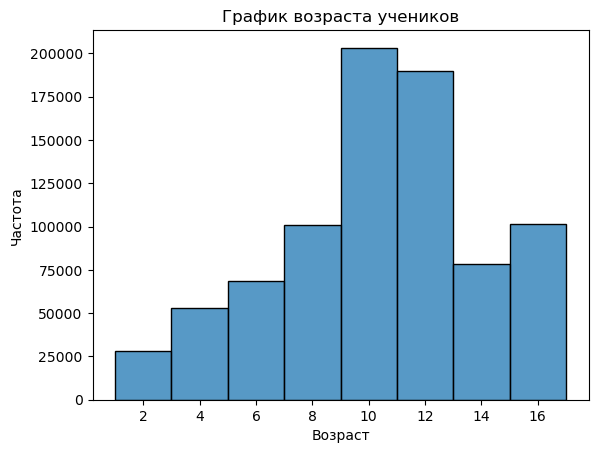

In [132]:
# Гистограмма
sns.histplot(final['pupil_category_new_id'], bins=8)

plt.title('График возраста учеников')
plt.xlabel('Возраст')
plt.ylabel('Частота')

plt.show()

In [133]:
#Разброс учеников составляет от нуля и до 17, заполним пропуски 0

In [134]:
#Заполним пропуски 0
final.subject_id.fillna(0, inplace=True)
final.pupil_category_new_id.fillna(0, inplace=True)

In [135]:
#Определим явные дубликаты и удалим их
final.duplicated().sum()

4391

In [136]:
final.drop_duplicates(inplace=True)

In [137]:
#Посмотрим распределение оплаченных и не оплаченных заказов
#Оплаченные заказы составляют 15 процентов
final['status_id_2'].value_counts(normalize=True)

status_id_2
0   0.850
1   0.150
Name: proportion, dtype: float64

Построим корреляционную матрицу  
Для этого удалим объектный признак

In [138]:
final_corr = final.copy()

In [139]:
final_corr.drop('purpose', axis=1, inplace=True)

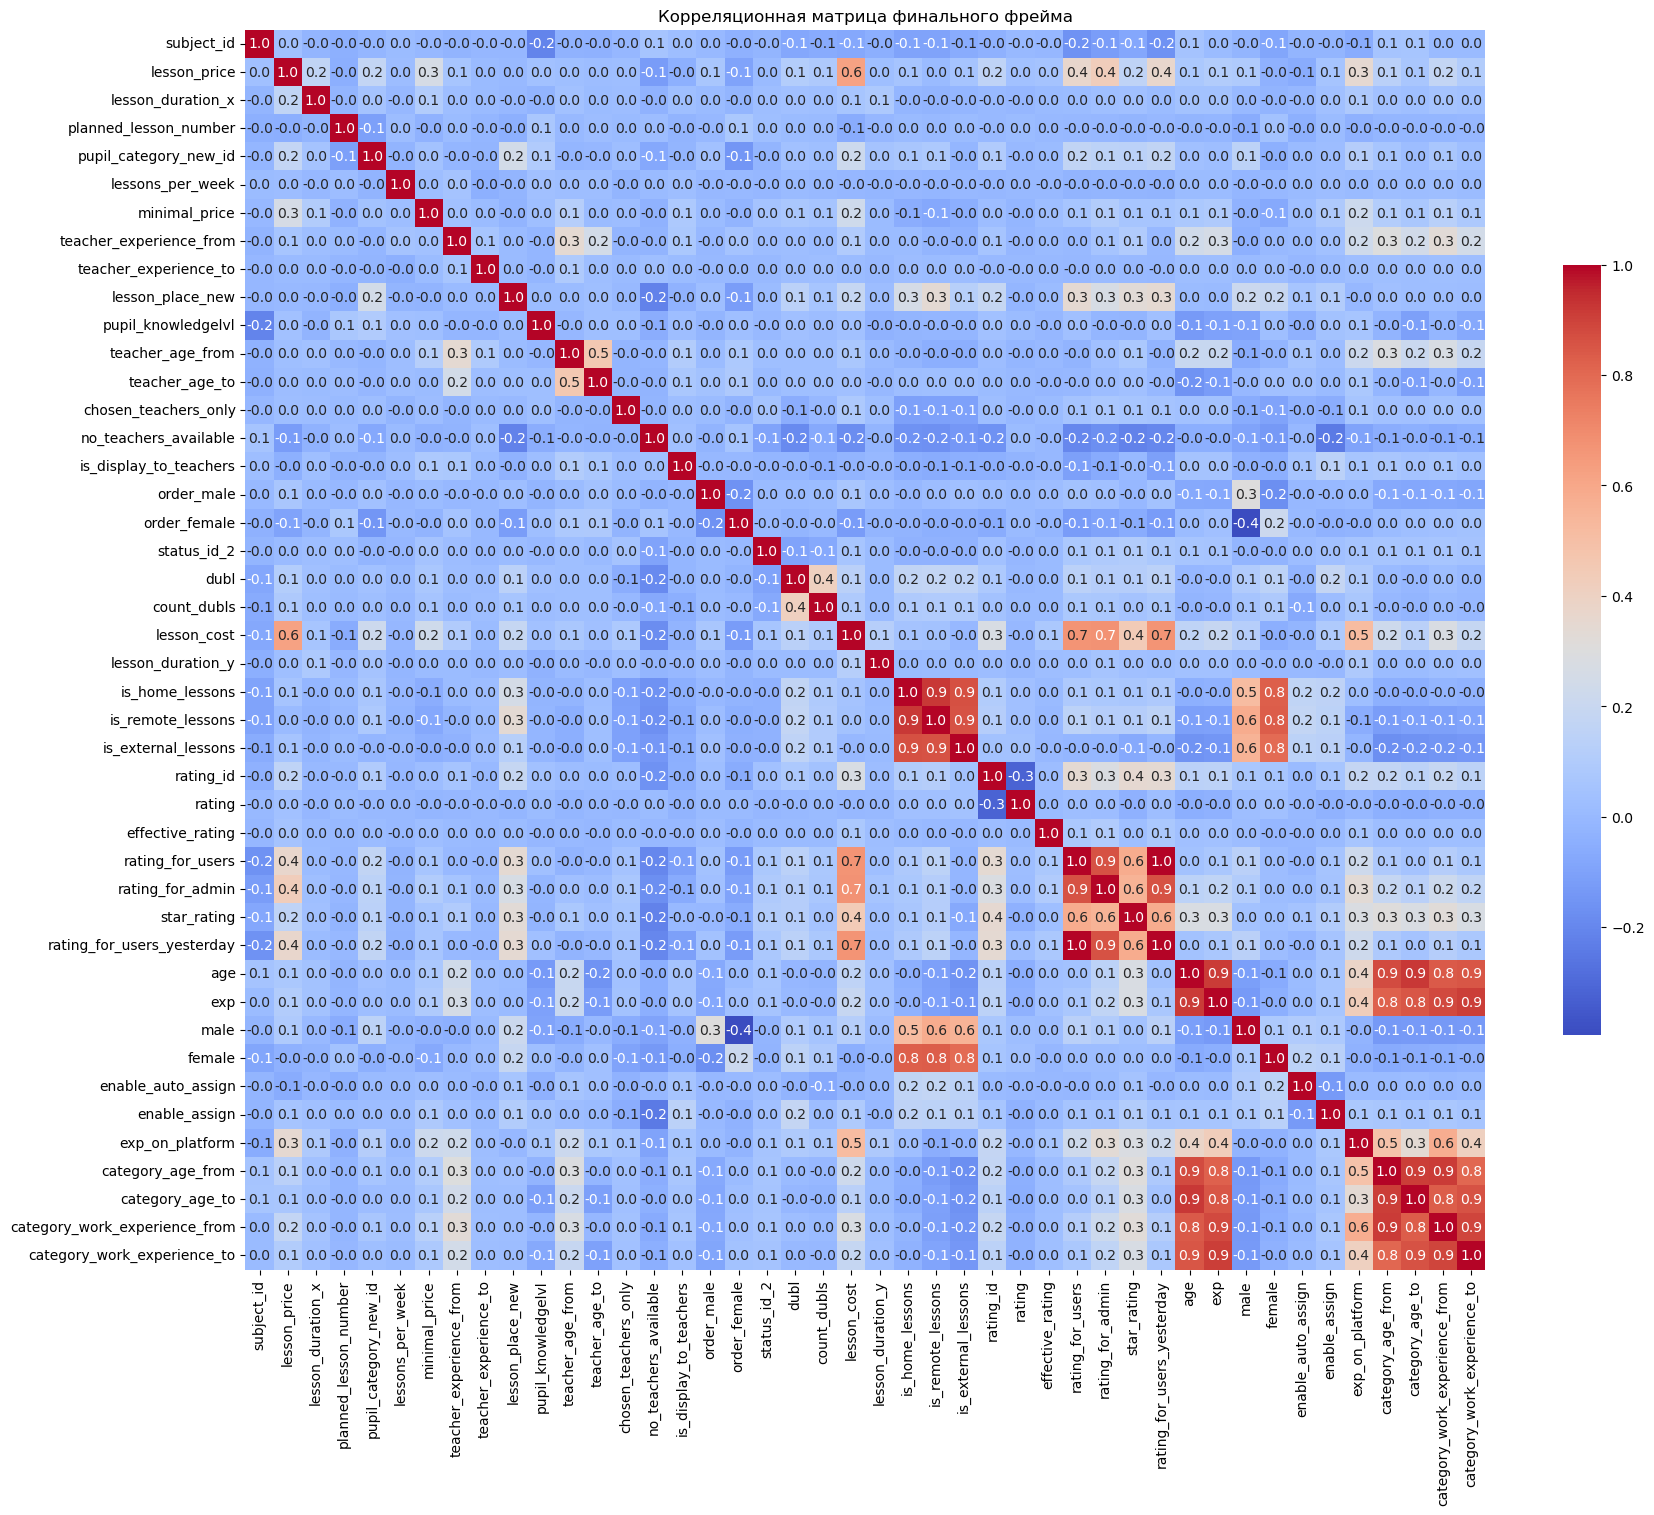

In [140]:
plt.figure(figsize=[20,20])
sns.heatmap(final_corr.corr(), annot=True, fmt='.1f', cmap='coolwarm', square=True, cbar_kws={'shrink': .5})
plt.title('Корреляционная матрица финального фрейма');

Признаков очень много, тяжело понять какие именно имеют высокую линейную зависимость (больше 0.8). Построим функцию

In [141]:
corr_matrix = final_corr.corr()

threshold = 0.8  
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):  
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j, corr_matrix.iloc[i, j]))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

high_corr_df

,Feature 1,Feature 2,Correlation
0,is_home_lessons,is_remote_lessons,0.921
1,is_home_lessons,is_external_lessons,0.865
2,is_home_lessons,female,0.828
3,is_remote_lessons,is_external_lessons,0.862
4,is_remote_lessons,female,0.833
5,rating_for_users,rating_for_admin,0.859
6,rating_for_users,rating_for_users_yesterday,1.000
7,rating_for_admin,rating_for_users_yesterday,0.859
8,age,exp,0.917
9,age,category_age_from,0.879


Можно сделать выводы, что есть признаки с высокой линейной зависимостью

## Выводы по блоку подготовка данных

1. Проведен разведочный анализ предоставленных данных
    - из четерых представленных таблиц отобрабраны 3 (orders, teachers_info, suitable_teachers)
    - в каждой из таблиц были выявлены аномальные значения и неподходящие признаки для последующего построения модели. Данные были удалены или изменены
    - практически все признаки, отобранные для построения модели, имеют графическую визуализацию или стат. анализ
2. Объединение таблиц
    - финальная таблица состоит из 3ех объединенных таблиц со следующей размерностью: (822838, 45).
    - 44 признака имеют числовые значения, 1 объектный.
    - на основе объектного признака далее будут созданы векторы

# Моделирование

## purpose векторизация

На основе признака 'purpose' создадим векторы

In [142]:
# Заменим пропущенные значения
final['purpose'].fillna('пропуск', inplace=True)

In [143]:
#Создадим функцию для преобразования значений в токены
def preprocess_text(text):
    text = str(text)
    
    text = re.sub(r'[^\w\s]', ' ', text, flags=re.UNICODE)
    
    text = text.lower()
    
    words = text.split()
    
    return words

In [144]:
final['tokenized_purpose'] = final['purpose'].apply(preprocess_text)

In [145]:
#Создадим модель
model = Word2Vec(final['tokenized_purpose'], vector_size=100, window=5, min_count=1, workers=4)

In [146]:
# Создадим функцию для получения вектора
def document_vector(word_list):
    # Удаление слов, которых нет в модели
    word_list = [word for word in word_list if word in model.wv.key_to_index]
    if len(word_list) == 0:
        return np.zeros(model.vector_size)
    # Усреднение векторов слов в предложении
    return np.mean(model.wv[word_list], axis=0)

In [147]:
final['purpose_vector'] = final['tokenized_purpose'].apply(document_vector)

In [148]:
#Преобразуем список векторов в датафрейм
vectors_df = pd.DataFrame(final['purpose_vector'].tolist())


In [149]:
#Посмотрим на данные
vectors_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1.513,0.708,-1.387,-0.809,1.366,-0.390,-1.626,2.558,-0.438,0.105,1.515,-1.872,0.150,-0.144,-1.737,-2.131,1.261,0.872,-0.809,0.011,-0.459,-0.613,-0.240,-0.364,1.014,1.009,-1.384,0.730,-0.932,-2.000,1.294,0.725,-1.009,0.370,-0.515,-0.378,0.629,-0.976,-0.742,-1.085,-0.567,0.802,-1.284,-0.671,0.222,-0.896,-1.014,0.112,1.444,-0.598,0.661,0.816,-0.446,-0.324,-0.476,-0.253,2.411,-0.191,-0.121,-0.653,1.671,-0.683,0.199,-0.214,0.108,-0.264,1.753,0.120,0.418,-0.544,0.655,-1.140,0.549,-0.913,-0.201,-0.365,1.462,0.204,-0.460,-0.283,1.516,2.465,1.142,1.489,-0.850,-0.308,0.188,-0.113,-0.119,-0.282,1.297,0.940,0.433,-1.218,0.275,1.335,-1.449,-0.880,-0.068,-0.312
1,2.061,1.234,-1.239,-1.013,2.741,-0.841,-0.280,3.103,-0.673,-0.039,0.521,-1.419,0.426,-0.508,-1.647,-2.832,1.480,1.109,-0.295,-0.621,-0.699,-1.211,-0.341,-0.549,1.175,0.872,-0.581,1.120,-1.056,-2.130,1.105,-0.126,-1.718,0.524,0.048,0.412,0.554,-0.862,-0.822,-0.872,-0.618,0.794,-1.417,-1.231,0.995,-1.927,-1.539,-0.302,0.974,-0.922,0.458,2.306,-0.295,-0.043,-1.134,0.772,2.271,-0.490,-0.036,-1.794,2.127,0.624,-0.282,-1.139,-0.026,0.000,0.930,-0.391,0.091,-0.553,0.951,-1.718,0.413,-1.110,-0.489,-0.324,0.868,0.560,-0.878,-0.533,1.132,1.555,-0.056,2.910,-1.203,0.159,0.372,1.202,-0.384,-0.992,1.310,1.448,0.090,-1.298,-0.383,1.398,-1.396,-1.572,0.055,-1.379
2,0.815,0.527,-0.616,-1.376,0.623,-0.199,-2.146,1.949,-1.441,0.442,0.622,-1.521,0.557,0.339,-1.695,-1.248,0.887,0.443,-0.143,0.485,0.306,-0.405,-0.410,-0.177,0.625,0.386,-1.652,0.210,-1.241,-1.263,1.485,1.047,-0.384,-0.319,-0.429,0.552,-0.685,-0.960,0.632,-1.608,-1.012,0.477,-1.582,-0.329,0.123,-0.798,-0.435,0.215,1.139,-0.573,1.313,-0.584,-0.275,0.931,-0.174,0.221,2.008,-0.010,-0.497,0.037,1.323,0.243,0.231,-0.377,0.087,0.024,1.735,0.345,0.773,-0.748,0.675,-0.562,0.691,-0.568,0.332,0.043,0.553,0.980,0.619,-0.634,1.347,2.427,0.668,1.070,-0.263,-0.251,0.566,-0.134,-0.098,-0.776,1.275,0.766,-0.259,-1.676,0.262,0.746,-1.732,-0.808,0.715,0.335
3,2.198,0.712,-0.564,-1.296,2.777,-0.873,-0.665,2.819,-1.380,0.071,0.447,-1.145,0.880,-0.128,-1.577,-3.018,1.415,1.288,-0.519,-0.617,-0.260,-0.900,-0.112,-0.260,1.351,0.630,-0.607,1.061,-1.296,-1.991,1.090,0.102,-0.883,0.636,0.012,0.720,-0.023,-0.652,-0.651,-1.168,-0.749,0.592,-1.709,-1.187,1.470,-2.028,-1.194,0.234,1.255,-0.522,0.153,1.787,0.299,0.513,-1.142,0.926,2.134,-0.221,-0.137,-1.324,1.804,0.959,-0.048,-1.649,-0.378,0.023,1.319,-0.331,0.458,-1.031,0.985,-2.218,0.647,-1.128,-0.813,-0.006,0.640,1.053,-0.712,-0.703,1.098,1.841,0.024,3.003,-0.852,0.613,0.079,0.728,-0.558,-1.126,1.160,1.238,-0.236,-1.570,-0.331,1.163,-1.683,-1.538,0.023,-1.023
4,1.405,0.663,-1.235,-1.143,0.572,-0.674,-1.245,2.512,-0.569,0.179,1.282,-1.693,0.140,0.266,-1.992,-1.651,1.358,0.713,-0.970,0.390,-0.447,-0.717,-0.196,-0.007,0.706,0.220,-1.349,0.391,-1.101,-1.965,1.303,0.798,-1.147,0.423,-0.374,-0.430,0.559,-1.028,-0.460,-1.484,-0.674,0.529,-1.164,-0.715,-0.014,-0.451,-0.554,0.386,1.155,-0.227,0.864,0.416,-0.540,-0.231,0.120,-0.138,2.771,-0.279,0.104,0.144,1.820,-0.425,0.231,-0.455,0.440,-0.241,2.189,0.369,0.166,-0.728,0.393,-1.104,0.436,-0.593,-0.135,0.149,1.097,0.284,0.268,-0.332,1.370,2.465,1.224,1.256,-0.424,-0.079,0.447,0.082,-0.191,0.443,1.203,1.146,0.477,-0.906,0.099,0.987,-1.824,-0.123,0.137,-0.513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822833,2.342,0.071,-0.073,-0.700,2.

In [150]:
# Сброс индексов 
final.reset_index(drop=True, inplace=True)
vectors_df.reset_index(drop=True, inplace=True)

In [151]:
# Объединение векторов предложений с исходным DataFrame
final = pd.concat([final, vectors_df], axis=1)

In [152]:
final.drop(['tokenized_purpose', 'purpose_vector','purpose'], axis=1, inplace=True)

In [168]:
final.head()

,subject_id,lesson_price,lesson_duration_x,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,order_male,order_female,status_id_2,dubl,count_dubls,lesson_cost,lesson_duration_y,is_home_lessons,is_remote_lessons,is_external_lessons,rating_id,rating,effective_rating,rating_for_users,rating_for_admin,star_rating,rating_for_users_yesterday,age,exp,male,female,enable_auto_assign,enable_assign,exp_on_platform,category_age_from,category_age_to,category_work_experience_from,category_work_experience_to,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,21.000,800,60,7,14.000,2,0,0,0,4,0,0.000,0.000,0,0,1,0,0,0,1,1,574.000,60.000,5,5,3,16.400,6.400,0.000,1072.500,309.025,4.919,1132.600,58.800,29.400,0,5,0,1,5.600,37.600,79.600,15.000,61.400,1.513,0.708,-1.387,-0.809,1.366,-0.390,-1.626,2.558,-0.438,0.105,1.515,-1.872,0.150,-0.144,-1.737,-2.131,1.261,0.872,-0.809,0.011,-0.459,-0.613,-0.240,-0.364,1.014,1.009,-1.384,0.730,-0.932,-2.000,1.294,0.725,-1.009,0.370,-0.515,-0.378,0.629,-0.976,-0.742,-1.085,-0.567,0.802,-1.284,-0.671,0.222,-0.896,-1.014,0.112,1.444,-0.598,0.661,0.816,-0.446,-0.324,-0.476,-0.253,2.411,-0.191,-0.121,-0.653,1.671,-0.683,0.199,-0.214,0.108,-0.264,1.753,0.120,0.418,-0.544,0.655,-1.140,0.549,-0.913,-0.201,-0.365,1.462,0.204,-0.460,-0.283,1.516,2.465,1.142,1.489,-0.850,-0.308,0.188,-0.113,-0.119,-0.282,1.297,0.940,0.433,-1.218,0.275,1.335,-1.449,-0.880,-0.068,-0.312
1,8.000,700,60,10,10.000,3,0,5,0,4,0,20.000,0.000,0,0,1,0,0,0,1,2,700.000,60.000,2,3,1,16.667,6.667,0.000,588.333,93.292,4.966,588.333,59.667,27.667,1,2,0,0,6.333,39.000,90.000,15.333,54.667,2.061,1.234,-1.239,-1.013,2.741,-0.841,-0.280,3.103,-0.673,-0.039,0.521,-1.419,0.426,-0.508,-1.647,-2.832,1.480,1.109,-0.295,-0.621,-0.699,-1.211,-0.341,-0.549,1.175,0.872,-0.581,1.120,-1.056,-2.130,1.105,-0.126,-1.718,0.524,0.048,0.412,0.554,-0.862,-0.822,-0.872,-0.618,0.794,-1.417,-1.231,0.995,-1.927,-1.539,-0.302,0.974,-0.922,0.458,2.306,-0.295,-0.043,-1.134,0.772,2.271,-0.490,-0.036,-1.794,2.127,0.624,-0.282,-1.139,-0.026,0.000,0.930,-0.391,0.091,-0.553,0.951,-1.718,0.413,-1.110,-0.489,-0.324,0.868,0.560,-0.878,-0.533,1.132,1.555,-0.056,2.910,-1.203,0.159,0.372,1.202,-0.384,-0.992,1.310,1.448,0.090,-1.298,-0.383,1.398,-1.396,-1.572,0.055,-1.379
2,21.000,3000,60,10,14.000,5,2000,0,0,4,0,0.000,0.000,0,0,1,0,0,0,1,1,1928.571,60.000,11,14,12,16.214,6.214,1.471,2722.643,781.232,4.914,2745.214,42.143,18.143,7,7,14,0,7.071,34.286,65.714,11.857,38.714,0.815,0.527,-0.616,-1.376,0.623,-0.199,-2.146,1.949,-1.441,0.442,0.622,-1.521,0.557,0.339,-1.695,-1.248,0.887,0.443,-0.143,0.485,0.306,-0.405,-0.410,-0.177,0.625,0.386,-1.652,0.210,-1.241,-1.263,1.485,1.047,-0.384,-0.319,-0.429,0.552,-0.685,-0.960,0.632,-1.608,-1.012,0.477,-1.582,-0.329,0.123,-0.798,-0.435,0.215,1.139,-0.573,1.313,-0.584,-0.275,0.931,-0.174,0.221,2.008,-0.010,-0.497,0.037,1.323,0.243,0.231,-0.377,0.087,0.024,1.735,0.345,0.773,-0.748,0.675,-0.562,0.691,-0.568,0.332,0.043,0.553,0.980,0.619,-0.634,1.347,2.427,0.668,1.070,-0.263,-0.251,0.566,-0.134,-0.098,-0.776,1.275,0.766,-0.259,-1.676,0.262,0.746,-1.732,-0.808,0.715,0.335
3,8.000,1500,60,10,9.000,2,0,0,0,1,0,0.000,0.000,0,0,1,0,0,0,1,1,967.857,60.000,2,8,14,14.857,-7174.571,1.889,865.571,656.009,4.700,871.179,38.714,16.500,2,12,6,1,7.929,33.143,51.857,11.286,26.643,2.198,0.712,-0.564,-1.296,2.777,-0.873,-0.665,2.819,-1.380,0.071,0.447,-1.145,0.880,-0.128,-1.577,-3.018,1.415,1.288,-0.519,-0.617,-0.260,-0.900,-0.112,-0.260,1.351,0.630,-0.607,1.061,-1.296,-1.991,1.090,0.102,-0.883,0.636,0.012,0.720,-0.023,-0.652,-0.651,-1.168,-

## Разбивка данных

In [153]:
#Разобъем данные на тренировочные, тестовые и валидационные
df_train, df_temp = train_test_split(final, test_size=0.25, random_state=12345)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345)

In [154]:
# Для обучающей выборки
features_train = df_train.drop(['status_id_2'], axis=1)
target_train = df_train['status_id_2']

# Для валидационной выборки
features_val = df_val.drop(['status_id_2'], axis=1)
target_val = df_val['status_id_2']

# Для тестовой выборки
features_test = df_test.drop(['status_id_2'], axis=1)
target_test = df_test['status_id_2']

In [155]:
#Приведем названия колонок к строковому типу данных
features_train.columns = features_train.columns.astype(str)
features_test.columns = features_test.columns.astype(str)
features_val.columns = features_val.columns.astype(str)

## Стандартизация

In [156]:
#Проведем стандартизацию
numeric = features_train.columns

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_val[numeric] = scaler.transform(features_val[numeric])

In [157]:
#Посомтрим на данные
features_train.head(5)

,subject_id,lesson_price,lesson_duration_x,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,order_male,order_female,dubl,count_dubls,lesson_cost,lesson_duration_y,is_home_lessons,is_remote_lessons,is_external_lessons,rating_id,rating,effective_rating,rating_for_users,rating_for_admin,star_rating,rating_for_users_yesterday,age,exp,male,female,enable_auto_assign,enable_assign,exp_on_platform,category_age_from,category_age_to,category_work_experience_from,category_work_experience_to,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
416836,-0.247,-0.492,-0.117,0.242,0.575,-0.456,-0.582,-0.543,-0.101,-1.520,-0.515,-0.753,-0.537,-0.158,-0.300,0.222,-0.211,1.286,-1.741,-0.711,-0.337,0.017,-0.897,-0.688,-0.561,0.738,0.153,-0.042,-0.740,-0.753,-1.169,-0.739,0.457,0.384,-0.514,-0.557,-0.272,-1.251,-0.744,0.254,0.913,0.059,0.604,1.008,0.937,-0.669,-0.041,0.671,-0.504,0.742,1.310,-0.000,-0.284,0.237,-0.808,0.241,0.158,-1.015,-0.649,0.134,0.417,-0.784,-0.043,-1.252,-0.951,0.431,0.401,0.526,0.012,0.470,0.988,0.180,-0.577,-0.222,0.099,-0.853,0.052,0.813,0.258,0.796,0.499,-0.678,0.161,-0.360,-0.023,-0.035,-0.850,0.744,-0.941,0.030,0.068,0.257,-0.610,-0.563,0.933,-0.618,-0.100,-0.192,0.437,0.618,0.012,0.305,-1.270,0.570,0.168,-0.497,0.860,0.129,-0.071,-0.699,-0.641,-0.314,0.371,0.584,-0.298,0.665,-0.807,-0.491,-0.291,0.768,0.231,-0.280,-0.539,0.222,0.046,-0.256,0.902,-0.880,0.365,0.185,0.548,-0.146,-0.610,1.305,0.952,1.072,-0.347,-0.200,0.616,0.129,-1.080,0.128,-0.691
582275,-1.185,-0.980,-0.117,0.242,-0.782,-1.371,0.377,1.264,-0.101,0.407,-0.515,-0.753,-0.537,-0.158,-0.300,0.222,-0.211,-0.778,0.574,0.182,-0.800,0.017,0.703,0.390,-0.014,0.032,-0.597,-0.038,-0.346,-0.311,0.543,-0.350,0.932,1.199,-0.514,0.706,-0.272,0.620,-0.232,0.838,0.828,0.915,0.865,1.190,0.422,-0.495,-0.463,0.548,-1.240,-0.135,0.622,-1.012,0.494,0.753,-0.143,0.971,0.936,-0.588,-0.888,0.876,0.041,-0.281,0.146,-0.046,-0.785,0.021,0.492,0.693,-0.700,0.423,-0.341,-0.488,-0.821,0.518,0.991,-0.576,1.270,-0.136,0.150,-0.333,0.486,-0.064,-1.186,-0.699,-0.398,-1.068,-0.852,0.946,-0.860,0.040,0.314,0.333,0.492,-0.613,0.636,0.712,0.289,-1.535,1.045,0.806,-0.815,-0.495,-0.803,0.571,0.265,-0.244,-1.240,0.418,0.684,0.186,-0.083,0.531,-0.672,-0.063,-1.579,1.269,-0.598,-0.322,-0.295,1.003,0.373,0.678,-0.258,0.338,0.287,-0.668,0.409,-0.337,0.833,0.132,-0.283,-0.721,-0.482,0.759,0.347,0.810,-0.912,-0.675,0.091,-0.918,-1.175,0.288,-0.638
5409,-1.051,-0.858,-0.117,0.242,1.389,1.373,0.137,-0.543,-0.101,0.407,2.757,-0.753,-0.537,-0.158,-0.300,0.222,-0.211,-0.778,0.574,-0.711,-0.534,0.017,0.007,0.183,-0.501,0.509,-0.769,-0.037,0.112,-0.442,0.583,0.125,0.025,0.070,0.359,-0.120,0.112,-1.251,-0.586,-0.209,-0.002,-0.127,0.205,-0.887,0.876,0.357,-0.963,-0.795,-1.583,-2.169,-1.323,-0.923,1.495,-0.889,0.065,1.355,0.421,0.323,0.737,0.112,-0.330,1.273,1.380,1.262,1.323,-0.696,-0.417,-0.646,-0.592,0.131,-0.425,-0.316,-0.589,0.416,0.976,0.129,-0.288,-0.199,-0.485,-2.111,-0.233,1.731,-1.567,-1.242,0.151,0.098,1.313,-0.275,0.647,0.128,-0.453,-0.357,-0.321,-0.070,-0.798,0.536,1.303,0.290,2.023,-0.326,0.051,-1.179,0.871,1.386,1.816,-0.964,0.399,0.141,1.565,1.376,-0.568,2.222,-1.127,-1.854,0.620,0.095,1.396,1.168,1.006,0.152,0.296,0.868,0.945,0.370,-1.128,-0.369,-1.248,-0.133,0.425,0.944,-0.951,1.993,-1.323,0.009,-0.509,-0.484,0.549,-0.667,-1.747,-1.363,0.156,0.593,1.764
208069,0.557,0.239,-0.117,0.242,0.032,-0.456,0.617,1.264,-0.101,2.334,-0.515,1.287,1.961,-0.158,-0.300,0.222,-0.211,-0.778,0.574,0.182,0.401,0.017,-0.619,-0.480,-0.379,1.400,0.153,-0.011,1.983,1.355,0.878,2.0

In [158]:
#Посомтри на размерность данных
display(features_train.shape)
display(features_test.shape)
display(features_val.shape)

(617128, 143)

(102855, 143)

(102855, 143)

## upsample

принято решение использовать встроенную балансировку в Catboost

In [159]:
# def upsample(features, target, repeat): 
#     features_zeros = features[target == 0] 
#     features_ones = features[target == 1] 
#     target_zeros = target[target == 0] 
#     target_ones = target[target == 1]
#     features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
#     target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
#     features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
#     return features_upsampled, target_upsampled

In [160]:
# features_upsampled, target_upsampled = upsample(features_train, target_train, 6)

In [161]:
# features_train = features_upsampled
# target_train = target_upsampled

## CatBoostClassifier

Создадим модель на базе CatBoostClassifier с 2 сетками (с балансировкой и без). Оптимальные параметры сразу представлены в обучении. Архив параметров прилагается

### Архив обучения

#### Результаты с балансировкой классов

```python  
Fitting 3 folds for each of 16 candidates, totalling 24 fits
[CV 1/3] END auto_class_weights=Balanced, depth=6, iterations=1000, learning_rate=0.1; f1_score: (test=0.563) precision_score: (test=0.582) roc_auc_score: (test=0.720) total time= 1.7min
[CV 2/3] END auto_class_weights=Balanced, depth=6, iterations=1000, learning_rate=0.1; f1_score: (test=0.563) precision_score: (test=0.582) roc_auc_score: (test=0.719) total time= 1.8min
[CV 3/3] END auto_class_weights=Balanced, depth=6, iterations=1000, learning_rate=0.1; f1_score: (test=0.565) precision_score: (test=0.583) roc_auc_score: (test=0.720) total time= 1.8min
[CV 1/3] END auto_class_weights=Balanced, depth=6, iterations=1000, learning_rate=0.01; f1_score: (test=0.547) precision_score: (test=0.578) roc_auc_score: (test=0.716) total time= 1.9min
[CV 2/3] END auto_class_weights=Balanced, depth=6, iterations=1000, learning_rate=0.01; f1_score: (test=0.546) precision_score: (test=0.577) roc_auc_score: (test=0.715) total time= 1.9min
[CV 3/3] END auto_class_weights=Balanced, depth=6, iterations=1000, learning_rate=0.01; f1_score: (test=0.548) precision_score: (test=0.578) roc_auc_score: (test=0.716) total time= 1.9min
[CV 1/3] END auto_class_weights=Balanced, depth=6, iterations=1500, learning_rate=0.1; f1_score: (test=0.568) precision_score: (test=0.582) roc_auc_score: (test=0.716) total time= 2.7min
[CV 2/3] END auto_class_weights=Balanced, depth=6, iterations=1500, learning_rate=0.1; f1_score: (test=0.567) precision_score: (test=0.581) roc_auc_score: (test=0.715) total time= 2.9min
[CV 3/3] END auto_class_weights=Balanced, depth=6, iterations=1500, learning_rate=0.1; f1_score: (test=0.569) precision_score: (test=0.582) roc_auc_score: (test=0.717) total time= 3.1min
[CV 1/3] END auto_class_weights=Balanced, depth=6, iterations=1500, learning_rate=0.01; f1_score: (test=0.549) precision_score: (test=0.580) roc_auc_score: (test=0.719) total time= 2.8min
[CV 2/3] END auto_class_weights=Balanced, depth=6, iterations=1500, learning_rate=0.01; f1_score: (test=0.549) precision_score: (test=0.579) roc_auc_score: (test=0.719) total time= 2.8min
[CV 3/3] END auto_class_weights=Balanced, depth=6, iterations=1500, learning_rate=0.01; f1_score: (test=0.550) precision_score: (test=0.580) roc_auc_score: (test=0.719) total time= 2.8min
[CV 1/3] END auto_class_weights=Balanced, depth=10, iterations=1000, learning_rate=0.1; f1_score: (test=0.589) precision_score: (test=0.582) roc_auc_score: (test=0.698) total time=11.0min
[CV 2/3] END auto_class_weights=Balanced, depth=10, iterations=1000, learning_rate=0.1; f1_score: (test=0.587) precision_score: (test=0.581) roc_auc_score: (test=0.696) total time=11.2min
[CV 3/3] END auto_class_weights=Balanced, depth=10, iterations=1000, learning_rate=0.1; f1_score: (test=0.589) precision_score: (test=0.583) roc_auc_score: (test=0.698) total time=10.8min
[CV 1/3] END auto_class_weights=Balanced, depth=10, iterations=1000, learning_rate=0.01; f1_score: (test=0.557) precision_score: (test=0.580) roc_auc_score: (test=0.719) total time=11.3min
[CV 2/3] END auto_class_weights=Balanced, depth=10, iterations=1000, learning_rate=0.01; f1_score: (test=0.558) precision_score: (test=0.581) roc_auc_score: (test=0.719) total time=11.2min
[CV 3/3] END auto_class_weights=Balanced, depth=10, iterations=1000, learning_rate=0.01; f1_score: (test=0.559) precision_score: (test=0.581) roc_auc_score: (test=0.719) total time=11.2min
[CV 1/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.1; f1_score: (test=0.589) precision_score: (test=0.582) roc_auc_score: (test=0.690) total time=16.5min
[CV 2/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.1; f1_score: (test=0.588) precision_score: (test=0.581) roc_auc_score: (test=0.688) total time=16.4min
[CV 3/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.1; f1_score: (test=0.589) precision_score: (test=0.582) roc_auc_score: (test=0.690) total time=16.5min
[CV 1/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.563) precision_score: (test=0.582) roc_auc_score: (test=0.721) total time=16.8min
[CV 2/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.563) precision_score: (test=0.582) roc_auc_score: (test=0.720) total time=17.1min
[CV 3/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.565) precision_score: (test=0.583) roc_auc_score: (test=0.721) total time=16.4min 
```           
            
            

#### Результаты без балансировкой классов

```python  
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.505) precision_score: (test=0.745) roc_auc_score: (test=0.722) total time=16.4min
[CV 2/3] END depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.503) precision_score: (test=0.748) roc_auc_score: (test=0.722) total time=16.6min
[CV 3/3] END depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.505) precision_score: (test=0.738) roc_auc_score: (test=0.722) total time=16.6min
``` 
            
     

### Обучение

In [162]:
%%time
model = CatBoostClassifier(task_type='CPU', verbose=False)

# Параметры для сетки с auto_class_weights='Balanced'
parameters_balanced = {
    'depth': [10],
    'learning_rate': [0.01],
    'iterations': [1500],
    'auto_class_weights': ['Balanced']
}

# Параметры для сетки без auto_class_weights (используется значение по умолчанию)
parameters_default = {
    'depth': [10],
    'learning_rate': [0.01],
    'iterations': [1500]
    # auto_class_weights не указан
}

# Объединение двух сеток параметров
parameters = [parameters_balanced, parameters_default]

scorers = {
    'precision_score': make_scorer(precision_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro'),
    'roc_auc_score': make_scorer(roc_auc_score, average='macro', needs_proba=True)
}

grid = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring=scorers,
    refit='roc_auc_score',  
    cv=3,  
    verbose=4,
    error_score='raise'
)

# Лучшая модель определяется по roc_auc_score

CPU times: total: 109 ms
Wall time: 113 ms


In [164]:
%%time
#Запустим обучение, определим лучшие параметры

grid.fit(features_train, target_train)

print('Лучшие параметры:', grid.best_params_)

best_model = grid.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.563) precision_score: (test=0.582) roc_auc_score: (test=0.721) total time=16.1min
[CV 2/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.563) precision_score: (test=0.582) roc_auc_score: (test=0.721) total time=16.2min
[CV 3/3] END auto_class_weights=Balanced, depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.564) precision_score: (test=0.582) roc_auc_score: (test=0.721) total time=16.4min
[CV 1/3] END depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.505) precision_score: (test=0.746) roc_auc_score: (test=0.722) total time=16.4min
[CV 2/3] END depth=10, iterations=1500, learning_rate=0.01; f1_score: (test=0.503) precision_score: (test=0.751) roc_auc_score: (test=0.722) total time=16.5min
[CV 3/3] END depth=10, iterations=1500, learning_rate=

### Расчет метрик

Метрики для класса 0 и класса 1:
Precision для класса 0: 0.8552801204522865
Precision для класса 1: 0.6235864297253635
Recall для класса 0: 0.994666788743033
Recall для класса 1: 0.0498772451221088
F1-score для класса 0: 0.9197223192270654
F1-score для класса 1: 0.0923665948791577
ROC AUC для класса 1: 0.7210400344757681
[[86911   466]
 [14706   772]]


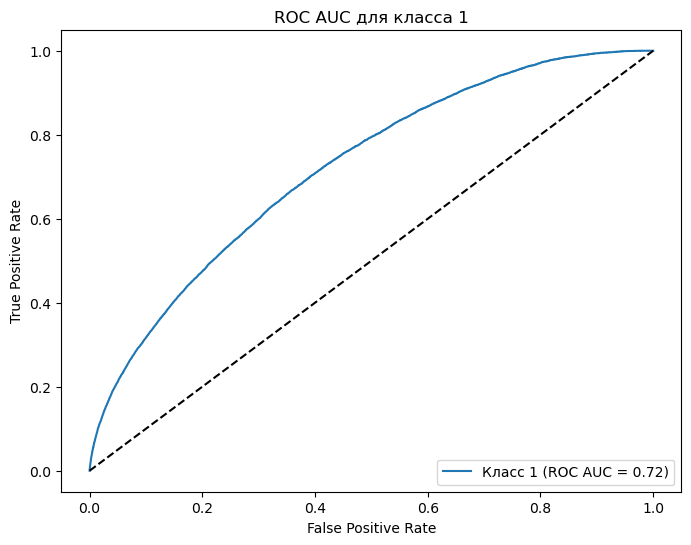

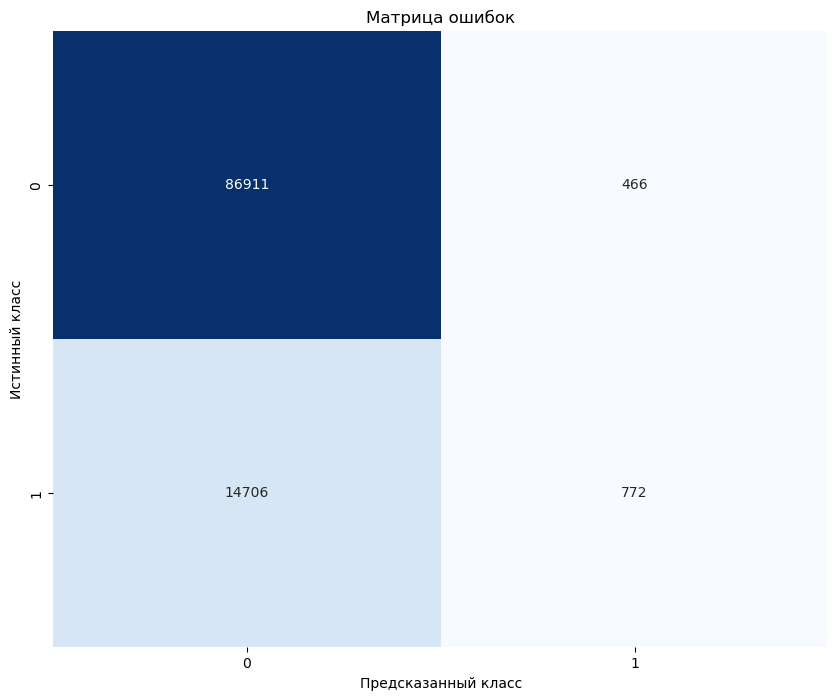

In [165]:
# Предсказание классов
preds_class = best_model.predict(features_test)

# Предсказание вероятностей для каждого класса
preds_proba = best_model.predict_proba(features_test)

# Расчет Precision, Recall и F1 для каждого класса
precision_per_class = precision_score(target_test, preds_class, average=None)
recall_per_class = recall_score(target_test, preds_class, average=None)
f1_per_class = f1_score(target_test, preds_class, average=None)

# Расчет ROC AUC 
fpr, tpr, _ = roc_curve(target_test, preds_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Расчет матрицы ошибок
confusion_mtx = confusion_matrix(target_test, preds_class)

# Вывод результатов
print("Метрики для класса 0 и класса 1:")
print(f"Precision для класса 0: {precision_per_class[0]}")
print(f"Precision для класса 1: {precision_per_class[1]}")
print(f"Recall для класса 0: {recall_per_class[0]}")
print(f"Recall для класса 1: {recall_per_class[1]}")
print(f"F1-score для класса 0: {f1_per_class[0]}")
print(f"F1-score для класса 1: {f1_per_class[1]}")
print(f"ROC AUC для класса 1: {roc_auc}")
print(confusion_mtx)

# График ROC AUC 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Класс 1 (ROC AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Диагональная линия для случайной модели
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC для класса 1')
plt.legend(loc="lower right")
plt.show()

# Построение графика матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

### Определение важности признаков

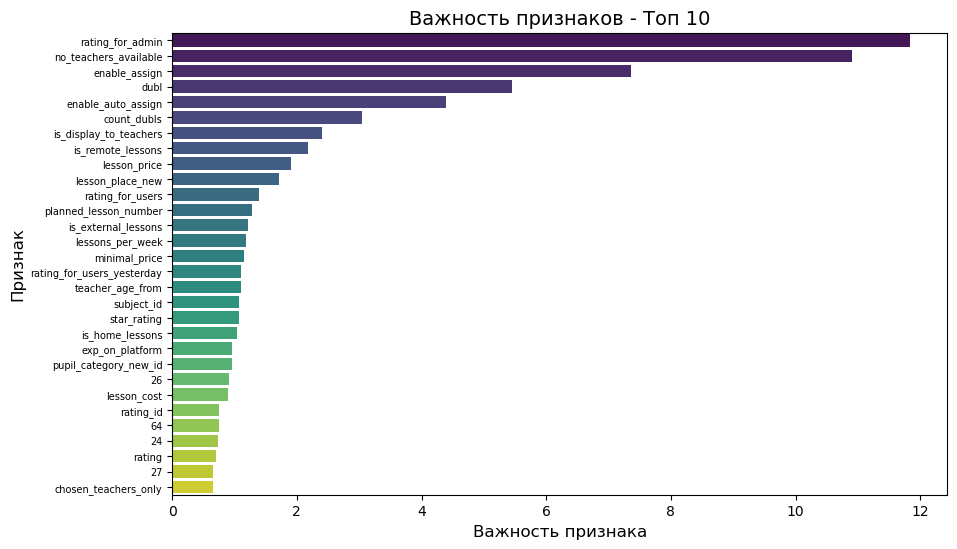

In [166]:
importances = best_model.feature_importances_

# Создание DataFrame с признаками и их важностью
feature_data = pd.DataFrame({'Feature': features_test.columns, 'Importance': importances})

# Сортировка признаков по важности в убывающем порядке
feature_data = feature_data.sort_values('Importance', ascending=False)

# Ограничение DataFrame первыми 10 признаками
top_features = feature_data.head(30)

# Построение графика
plt.figure(figsize=(10, 6))
bplot = sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Важность признаков - Топ 10', fontsize=14)
plt.xlabel('Важность признака', fontsize=12)
plt.ylabel('Признак', fontsize=12)

plt.yticks(fontsize=7)
plt.xticks(fontsize=10)

plt.show()

## Калибровка вероятностей

In [167]:
# Калибровка модели
calibrated_clf = CalibratedClassifierCV(estimator=grid.best_estimator_, method='sigmoid', cv='prefit')
calibrated_clf.fit(features_val, target_val)

# Предсказание на валидационной выборке
target_val_pred = calibrated_clf.predict(features_val)
target_val_pred_proba = calibrated_clf.predict_proba(features_val)

# Вычисление метрик для каждого класса
precision = precision_score(target_val, target_val_pred, average=None, zero_division=0)
recall = recall_score(target_val, target_val_pred, average=None, zero_division=0)
f1 = f1_score(target_val, target_val_pred, average=None, zero_division=0)

# Выбор вероятностей для класса 1 (положительного класса)
target_val_pred_proba_class1 = target_val_pred_proba[:, 1]

# Расчет ROC AUC
roc_auc = roc_auc_score(target_val, target_val_pred_proba_class1)

# Вывод результатов
print("Precision по классам: ", precision)
print("Recall по классам: ", recall)
print("F1 Score по классам: ", f1)
print("ROC AUC по классам: ", roc_auc)

Precision по классам:  [0.86069577 0.56607495]
Recall по классам:  [0.98742066 0.09312135]
F1 Score по классам:  [0.91971347 0.15993313]
ROC AUC по классам:  0.7183323749731406


## Выводы по этапу Моделирование

1. Была проведена вектроризация одного из объектных признаков, после чего финальный фрейм пополнился 100 новыми признаками
2. Произведена разбивка данных на тренировочную, тестовую и валидачионную выборки
3. Произведена стандартизация признаков 
4. Балансировка классов была использована внутри параметров выбранной модели
5. В качестве модели выбрана  CatBoostClassifier (после перебора параметров с использованием GridSearchCV, выбраны лучшие параметры: 
    - {'depth': 10, 'iterations': 1500, 'learning_rate': 0.01}
6. Были достигнуты следующие результаты по метрикам до калибровки вероятностей:
    - Precision для класса 0: 0.8553965473120608
    - Precision для класса 1: 0.627294493216281
    - Recall для класса 0: 0.9946553440836834
    - Recall для класса 1: 0.05078175474867554
    - F1-score для класса 0: 0.9197847379867604
    - F1-score для класса 1: 0.09395732472655549
    - ROC AUC для класса 1: 0.7215379999003063
7. Результаты после калибровки вероятностей:
    - Precision по классам:  [0.86042433 0.55980861]
    - Recall по классам:  [0.98737492 0.09110967]
    - F1 Score по классам:  [0.91953864 0.15671392]
    - ROC AUC по классам:  0.7182046406550011

# Общий вывод

По условию заказчика была разработана модель которая по имеющейся информации о клиенте и заявке будет предсказывать
вероятность оплаты заявки клиентом. Для достижения поставленной цели были выполнены следущие шаги:
1. Разведочный анализ (EDA)
     - Данный раздел включал в себя первичный осмотр предоставленных данных с дальнейшей подготовкой к построению модели
2. Моделирование
    - На данном этапе осуществлялась финальная подготовка данных (стандартизация, векторизация), определялись оптимальные гипперпараметры модели
   - Построение и обучкение модели
   - Калибровка вероятностей
   
Каждый шаг сопровождался комментариями и общими выводами. В результате удалось добиться следующих результатов выбранных метрик заказчика:
- До калибровки вероятностей:
    - Precision для класса 0: 0.8553965473120608
    - Precision для класса 1: 0.627294493216281
    - Recall для класса 0: 0.9946553440836834
    - Recall для класса 1: 0.05078175474867554
    - F1-score для класса 0: 0.9197847379867604
    - F1-score для класса 1: 0.09395732472655549
    - ROC AUC для класса 1: 0.7215379999003063
- Результаты после калибровки вероятностей:
    - Precision по классам:  [0.86042433 0.55980861]
    - Recall по классам:  [0.98737492 0.09110967]
    - F1 Score по классам:  [0.91953864 0.15671392]
    - ROC AUC по классам:  0.7182046406550011